In [1]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [2]:
from imputation import run_comparing

In [3]:
qual_cols = { "age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG" }
cat_cols = { "sex", "on_thyroxine", "on_antithyroid_meds", "sick", "pregnant", "thyroid_surgery", "I131_treatment", "lithium", "goitre", "tumor", "psych", "referral_source", "target" }

In [4]:
remove_qual_cols = { "TBG" }
remove_cat_cols = { "referral_source", "target" }

In [5]:
k = 5
neighbours = 10
iters = 10

In [6]:
seed = 42

In [7]:
random_state = np.random.RandomState(seed)
random_generator = np.random.default_rng(seed)

In [8]:
sel_qual_cols = list(qual_cols.difference(remove_qual_cols))
sel_cat_cols = list(cat_cols.difference(remove_cat_cols))
only_sel_qual_cols = sel_qual_cols.copy()
sel_qual_cols.extend(sel_cat_cols)
display(sel_qual_cols)
display(sel_cat_cols)

['T3',
 'TSH',
 'TT4',
 'FTI',
 'T4U',
 'age',
 'I131_treatment',
 'on_antithyroid_meds',
 'thyroid_surgery',
 'on_thyroxine',
 'lithium',
 'psych',
 'sick',
 'tumor',
 'goitre',
 'pregnant',
 'sex']

['I131_treatment',
 'on_antithyroid_meds',
 'thyroid_surgery',
 'on_thyroxine',
 'lithium',
 'psych',
 'sick',
 'tumor',
 'goitre',
 'pregnant',
 'sex']

In [9]:
df = pd.read_csv("./data/thyroidDF.csv")
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


In [10]:
df.dropna()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
167,40,F,f,f,f,f,f,f,f,f,...,3.9,t,0.83,t,5.0,t,28.0,other,F,840827019
5256,35,F,f,f,f,f,f,t,f,f,...,73.0,t,1.16,t,63.0,t,37.0,other,-,851128040
6044,77,F,f,f,f,f,f,f,f,f,...,120.0,t,0.96,t,124.0,t,45.0,SVI,-,860305064
6045,73,M,f,f,f,f,f,f,f,f,...,89.0,t,0.74,t,119.0,t,24.0,SVI,-,860305065
6747,77,F,f,f,f,f,f,f,f,f,...,131.0,t,1.04,t,126.0,t,25.0,SVI,K,860702030
6773,74,F,f,f,f,f,f,f,f,f,...,116.0,t,0.81,t,143.0,t,22.0,SVI,-,860703046
6862,60,M,f,f,f,f,f,f,f,f,...,92.0,t,0.84,t,110.0,t,21.0,other,-,860710043
6863,66,F,f,f,f,f,f,f,f,f,...,138.0,t,0.80,t,173.0,t,15.0,SVI,-,860710044
6880,42,F,f,f,f,f,f,f,f,f,...,106.0,t,0.98,t,108.0,t,27.0,other,-,860711039
6934,29,F,f,f,f,f,f,f,f,f,...,122.0,t,1.14,t,107.0,t,36.0,SVI,-,860717007


In [11]:
df[sel_qual_cols]

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex
0,NaN,0.3,NaN,NaN,NaN,29,f,f,f,f,f,f,f,f,f,f,F
1,1.9,1.6,128.0,NaN,NaN,29,f,f,f,f,f,f,f,f,f,f,F
2,NaN,NaN,NaN,NaN,NaN,41,f,f,f,f,f,f,f,f,f,f,F
3,NaN,NaN,NaN,NaN,NaN,36,f,f,f,f,f,f,f,f,f,f,F
4,NaN,NaN,NaN,NaN,NaN,32,f,f,f,f,f,f,f,f,f,f,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,NaN,NaN,64.0,77.0,0.83,56,f,f,f,f,f,f,f,f,f,f,M
9168,NaN,NaN,91.0,99.0,0.92,22,f,f,f,f,f,f,f,f,f,f,M
9169,NaN,NaN,113.0,89.0,1.27,69,f,f,f,f,f,f,f,f,f,f,M
9170,NaN,NaN,75.0,88.0,0.85,47,f,f,f,f,f,f,f,f,f,f,F


In [12]:
df[sel_cat_cols]

,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex
0,f,f,f,f,f,f,f,f,f,f,F
1,f,f,f,f,f,f,f,f,f,f,F
2,f,f,f,f,f,f,f,f,f,f,F
3,f,f,f,f,f,f,f,f,f,f,F
4,f,f,f,f,f,f,f,f,f,f,F
...,...,...,...,...,...,...,...,...,...,...,...
9167,f,f,f,f,f,f,f,f,f,f,M
9168,f,f,f,f,f,f,f,f,f,f,M
9169,f,f,f,f,f,f,f,f,f,f,M
9170,f,f,f,f,f,f,f,f,f,f,F


In [13]:
df = df[(df["age"] >= 0) & (df["age"] < 100)]
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


In [14]:
qual_na_df = df[sel_qual_cols].dropna()
qual_na_df

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex
19,2.4,1.50,90.0,85.0,1.06,36,f,f,f,f,f,f,f,f,f,f,F
21,2.3,1.20,104.0,96.0,1.08,40,f,f,f,f,f,f,f,f,f,f,F
22,2.1,5.90,88.0,105.0,0.84,40,f,f,f,f,f,f,f,f,f,f,F
23,2.4,0.05,107.0,95.0,1.13,77,f,f,f,f,f,f,f,f,f,f,F
27,2.1,0.05,93.0,106.0,0.87,51,f,f,f,f,f,f,f,f,f,f,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,1.8,0.73,85.0,94.0,0.90,65,f,f,f,f,f,f,f,f,f,f,M
9130,2.1,4.10,135.0,113.0,1.19,65,t,f,f,t,f,f,f,f,f,f,F
9134,1.0,53.00,49.0,39.0,1.25,74,f,f,f,f,f,f,t,f,f,f,F
9137,1.3,2.30,59.0,81.0,0.73,42,f,f,f,t,f,f,f,f,f,f,F


In [15]:
categorical_dict = {
    "f" : 0,
    "t" : 1,
    "F" : 0,
    "M" : 1
}

def replace_col(series, col):
    series[col] = categorical_dict[series[col]]
    return series

for col in sel_cat_cols:
    qual_na_df = qual_na_df.apply(lambda s : replace_col(s, col), axis=1)

In [16]:
qual_na_df

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex
19,2.4,1.50,90.0,85.0,1.06,36,0,0,0,0,0,0,0,0,0,0,0
21,2.3,1.20,104.0,96.0,1.08,40,0,0,0,0,0,0,0,0,0,0,0
22,2.1,5.90,88.0,105.0,0.84,40,0,0,0,0,0,0,0,0,0,0,0
23,2.4,0.05,107.0,95.0,1.13,77,0,0,0,0,0,0,0,0,0,0,0
27,2.1,0.05,93.0,106.0,0.87,51,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,1.8,0.73,85.0,94.0,0.90,65,0,0,0,0,0,0,0,0,0,0,1
9130,2.1,4.10,135.0,113.0,1.19,65,1,0,0,1,0,0,0,0,0,0,0
9134,1.0,53.00,49.0,39.0,1.25,74,0,0,0,0,0,0,1,0,0,0,0
9137,1.3,2.30,59.0,81.0,0.73,42,0,0,0,1,0,0,0,0,0,0,0


In [17]:
from utils.data_split import k_fold_split

In [18]:
complete_vals_df, remove_vals_df = k_fold_split(qual_na_df, k, random_generator)
missing_vals_idxs = list(remove_vals_df.index)

real_df = pd.concat([complete_vals_df, remove_vals_df])

## Non Weighted KNN

In [19]:
knn_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    knn_imputer = KNNImputer(n_neighbors=neighbours)
    knn_imputed_mat = knn_imputer.fit_transform(curr_df)
    
    knn_imputed_df = pd.DataFrame(knn_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    knn_imputed_df["{} (real)".format(col)] = real_df[col]
    knn_imputed_df["{} (imputed)".format(col)] = knn_imputed_df[col]
    knn_imputed_df.drop([col], axis=1, inplace=True)

    knn_imputed_df = knn_imputed_df.loc[missing_vals_idxs]

    knn_imputed_df_map[col] = knn_imputed_df

In [20]:
def col_mse(df : pd.DataFrame, col : str) -> float:
    sqr_err_list = (df[col + " (real)"] - df[col + " (imputed)"]).to_numpy() ** 2
    sqr_err_sum = sqr_err_list.sum()
    mean_sqr_err = sqr_err_sum / sqr_err_list.size
    return mean_sqr_err

In [21]:
for col, knn_imputed_df in knn_imputed_df_map.items():
    display("{} with KNN".format(col))
    display(col_mse(knn_imputed_df, col))
    display(knn_imputed_df)

'T3 with KNN'

0.4298722789291883

,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,T3 (real),T3 (imputed)
2264,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,1.290
3237,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.5,2.350
6844,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.3,2.130
6496,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.3,1.440
5356,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2,2.110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.7,1.693
1031,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,3.820
1677,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.290
6258,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,2.190


'TSH with KNN'

489.68431802480444

,T3,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,TSH (real),TSH (imputed)
2264,0.7,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,1.6040
3237,2.5,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.30,1.6715
6844,2.3,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.70,1.8840
6496,1.3,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.10,2.5560
5356,1.2,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.30,1.7400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,2.5380
1031,2.5,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.3710
1677,3.0,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,1.1970
6258,1.3,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.30,6.6920


'TT4 with KNN'

464.3116705112263

,T3,TSH,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,TT4 (real),TT4 (imputed)
2264,0.7,0.10,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,71.0,94.9
3237,2.5,2.30,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,130.0,123.5
6844,2.3,2.70,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,91.0,89.5
6496,1.3,2.10,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,52.0,56.6
5356,1.2,2.30,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,107.0,96.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,90.0,118.0
1031,2.5,0.25,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269.0,148.0
1677,3.0,1.00,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,224.0,132.8
6258,1.3,3.30,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,71.3


'FTI with KNN'

432.2338955660726

,T3,TSH,TT4,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,FTI (real),FTI (imputed)
2264,0.7,0.10,71.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,96.0,87.5
3237,2.5,2.30,130.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.0,125.4
6844,2.3,2.70,91.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,92.0,97.8
6496,1.3,2.10,52.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,63.0,64.0
5356,1.2,2.30,107.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,105.0,114.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.0,99.1
1031,2.5,0.25,269.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.0,271.7
1677,3.0,1.00,224.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,136.0,164.9
6258,1.3,3.30,67.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,78.4


'T4U with KNN'

0.003298317582037996

,T3,TSH,TT4,FTI,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,T4U (real),T4U (imputed)
2264,0.7,0.10,71.0,96.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.74,0.734
3237,2.5,2.30,130.0,129.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.01,1.003
6844,2.3,2.70,91.0,92.0,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.99,0.986
6496,1.3,2.10,52.0,63.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.83,0.822
5356,1.2,2.30,107.0,105.0,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.01,1.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.70,0.691
1031,2.5,0.25,269.0,165.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.63,1.396
1677,3.0,1.00,224.0,136.0,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.65,1.551
6258,1.3,3.30,67.0,70.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.96,0.981


'age with KNN'

386.6717530224525

,T3,TSH,TT4,FTI,T4U,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,age (real),age (imputed)
2264,0.7,0.10,71.0,96.0,0.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,64.1
3237,2.5,2.30,130.0,129.0,1.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,55.5
6844,2.3,2.70,91.0,92.0,0.99,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,58.0,51.6
6496,1.3,2.10,52.0,63.0,0.83,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,49.1
5356,1.2,2.30,107.0,105.0,1.01,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.0,57.0
1031,2.5,0.25,269.0,165.0,1.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,36.9
1677,3.0,1.00,224.0,136.0,1.65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0,37.2
6258,1.3,3.30,67.0,70.0,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,63.5


'I131_treatment with KNN'

0.0185146804835924

,T3,TSH,TT4,FTI,T4U,age,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,I131_treatment (real),I131_treatment (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'on_antithyroid_meds with KNN'

0.011105354058721935

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,on_antithyroid_meds (real),on_antithyroid_meds (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3


'thyroid_surgery with KNN'

0.022996545768566492

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,thyroid_surgery (real),thyroid_surgery (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'on_thyroxine with KNN'

0.09664939550949915

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,lithium,psych,sick,tumor,goitre,pregnant,sex,on_thyroxine (real),on_thyroxine (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.3
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.3
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'lithium with KNN'

0.010207253886010365

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,psych,sick,tumor,goitre,pregnant,sex,lithium (real),lithium (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'psych with KNN'

0.05491364421416235

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,sick,tumor,goitre,pregnant,sex,psych (real),psych (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.4
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'sick with KNN'

0.04442141623488773

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,tumor,goitre,pregnant,sex,sick (real),sick (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.1
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1


'tumor with KNN'

0.02541450777202073

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,goitre,pregnant,sex,tumor (real),tumor (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.1
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'goitre with KNN'

0.011278065630397236

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,pregnant,sex,goitre (real),goitre (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'pregnant with KNN'

0.008903281519861833

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,sex,pregnant (real),pregnant (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'sex with KNN'

0.21466321243523317

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex (real),sex (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.3
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.2
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3


## KNN Weighted

In [22]:
wknn_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    wknn_imputer = KNNImputer(n_neighbors=neighbours, weights="distance")
    wknn_imputed_mat = wknn_imputer.fit_transform(curr_df)
    
    wknn_imputed_df = pd.DataFrame(wknn_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    wknn_imputed_df["{} (real)".format(col)] = real_df[col]
    wknn_imputed_df["{} (imputed)".format(col)] = wknn_imputed_df[col]
    wknn_imputed_df.drop([col], axis=1, inplace=True)

    wknn_imputed_df = wknn_imputed_df.loc[missing_vals_idxs]

    wknn_imputed_df_map[col] = wknn_imputed_df

In [23]:
for col, wknn_imputed_df in wknn_imputed_df_map.items():
    display("{} with WKNN".format(col))
    display(col_mse(wknn_imputed_df, col))
    display(wknn_imputed_df)

'T3 with WKNN'

0.42560673549855255

,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,T3 (real),T3 (imputed)
2264,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,1.221420
3237,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.5,2.330250
6844,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.3,2.171254
6496,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.3,1.426905
5356,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2,2.172360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.7,1.689304
1031,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,3.765846
1677,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.292932
6258,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,2.120227


'TSH with WKNN'

441.98005039903137

,T3,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,TSH (real),TSH (imputed)
2264,0.7,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,1.455697
3237,2.5,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.30,1.645256
6844,2.3,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.70,1.968932
6496,1.3,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.10,2.324797
5356,1.2,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.30,1.783195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,2.286066
1031,2.5,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.326254
1677,3.0,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,2.709227
6258,1.3,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.30,6.390841


'TT4 with WKNN'

461.9628696497884

,T3,TSH,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,TT4 (real),TT4 (imputed)
2264,0.7,0.10,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,71.0,86.931099
3237,2.5,2.30,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,130.0,123.765035
6844,2.3,2.70,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,91.0,89.317557
6496,1.3,2.10,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,52.0,56.767783
5356,1.2,2.30,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,107.0,96.982087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,90.0,119.569943
1031,2.5,0.25,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269.0,148.057811
1677,3.0,1.00,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,224.0,132.120839
6258,1.3,3.30,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,69.939648


'FTI with WKNN'

420.7936683391995

,T3,TSH,TT4,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,FTI (real),FTI (imputed)
2264,0.7,0.10,71.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,96.0,88.667849
3237,2.5,2.30,130.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.0,126.506656
6844,2.3,2.70,91.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,92.0,98.674307
6496,1.3,2.10,52.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,63.0,62.541706
5356,1.2,2.30,107.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,105.0,113.848562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.0,99.230299
1031,2.5,0.25,269.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.0,273.318489
1677,3.0,1.00,224.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,136.0,183.884151
6258,1.3,3.30,67.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,78.278091


'T4U with WKNN'

0.0031193387767534035

,T3,TSH,TT4,FTI,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,T4U (real),T4U (imputed)
2264,0.7,0.10,71.0,96.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.74,0.732350
3237,2.5,2.30,130.0,129.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.01,1.005598
6844,2.3,2.70,91.0,92.0,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.99,0.983308
6496,1.3,2.10,52.0,63.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.83,0.817616
5356,1.2,2.30,107.0,105.0,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.01,1.021244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.70,0.688861
1031,2.5,0.25,269.0,165.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.63,1.427296
1677,3.0,1.00,224.0,136.0,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.65,1.576008
6258,1.3,3.30,67.0,70.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.96,0.977007


'age with WKNN'

389.06791718864423

,T3,TSH,TT4,FTI,T4U,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,age (real),age (imputed)
2264,0.7,0.10,71.0,96.0,0.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,63.334378
3237,2.5,2.30,130.0,129.0,1.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,54.672971
6844,2.3,2.70,91.0,92.0,0.99,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,58.0,52.847082
6496,1.3,2.10,52.0,63.0,0.83,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,49.400212
5356,1.2,2.30,107.0,105.0,1.01,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0,52.448180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.0,59.046203
1031,2.5,0.25,269.0,165.0,1.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,36.148283
1677,3.0,1.00,224.0,136.0,1.65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0,36.372909
6258,1.3,3.30,67.0,70.0,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,65.178781


'I131_treatment with WKNN'

0.018685980659860293

,T3,TSH,TT4,FTI,T4U,age,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,I131_treatment (real),I131_treatment (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'on_antithyroid_meds with WKNN'

0.011287600422850083

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,on_antithyroid_meds (real),on_antithyroid_meds (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076813
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282255


'thyroid_surgery with WKNN'

0.023177645010056903

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,thyroid_surgery (real),thyroid_surgery (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'on_thyroxine with WKNN'

0.09798349159857307

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,lithium,psych,sick,tumor,goitre,pregnant,sex,on_thyroxine (real),on_thyroxine (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.241897
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.082344
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.535102
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.356978
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


'lithium with WKNN'

0.010136516858125541

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,psych,sick,tumor,goitre,pregnant,sex,lithium (real),lithium (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.080835
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


'psych with WKNN'

0.05575754469973861

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,sick,tumor,goitre,pregnant,sex,psych (real),psych (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.465646
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.079070
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


'sick with WKNN'

0.04467850664634335

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,tumor,goitre,pregnant,sex,sick (real),sick (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.080835
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115528


'tumor with WKNN'

0.026144648684134218

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,goitre,pregnant,sex,tumor (real),tumor (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.081862
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


'goitre with WKNN'

0.011330425081952

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,pregnant,sex,goitre (real),goitre (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.081909
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


'pregnant with WKNN'

0.008953280242729981

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,sex,pregnant (real),pregnant (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.084894
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178761
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.372184
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


'sex with WKNN'

0.21644934192439338

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex (real),sex (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.722885
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.441785
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.348118
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.202090
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.728067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.675478
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113863
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222580


## MICE

In [24]:
mice_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    mice_imputer = IterativeImputer(random_state=random_state, max_iter=iters)
    mice_imputed_mat = mice_imputer.fit_transform(curr_df)
    
    mice_imputed_df = pd.DataFrame(mice_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    mice_imputed_df["{} (real)".format(col)] = real_df[col]
    mice_imputed_df["{} (imputed)".format(col)] = mice_imputed_df[col]
    mice_imputed_df.drop([col], axis=1, inplace=True)

    mice_imputed_df = mice_imputed_df.loc[missing_vals_idxs]

    mice_imputed_df_map[col] = mice_imputed_df

In [25]:
for col, mice_imputed_df in mice_imputed_df_map.items():
    display("{} with MICE".format(col))
    display(col_mse(mice_imputed_df, col))
    display(mice_imputed_df)

'T3 with MICE'

0.440815105762961

,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,T3 (real),T3 (imputed)
2264,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,1.300659
3237,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.5,2.402895
6844,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.3,1.798499
6496,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.3,1.255361
5356,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2,1.868217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.7,1.924874
1031,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,4.021503
1677,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.808192
6258,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,1.402957


'TSH with MICE'

762.899839818064

,T3,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,TSH (real),TSH (imputed)
2264,0.7,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,5.341304
3237,2.5,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.30,-1.227369
6844,2.3,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.70,4.286202
6496,1.3,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.10,9.330787
5356,1.2,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.30,6.942474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,-0.965307
1031,2.5,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,-27.219357
1677,3.0,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,-12.708742
6258,1.3,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.30,13.915500


'TT4 with MICE'

62.635884098942704

,T3,TSH,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,TT4 (real),TT4 (imputed)
2264,0.7,0.10,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,71.0,68.349566
3237,2.5,2.30,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,130.0,126.843567
6844,2.3,2.70,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,91.0,91.293718
6496,1.3,2.10,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,52.0,48.264870
5356,1.2,2.30,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,107.0,105.999505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,90.0,91.432815
1031,2.5,0.25,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269.0,227.363096
1677,3.0,1.00,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,224.0,201.858256
6258,1.3,3.30,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,68.141633


'FTI with MICE'

69.21470658031369

,T3,TSH,TT4,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,FTI (real),FTI (imputed)
2264,0.7,0.10,71.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,96.0,99.018203
3237,2.5,2.30,130.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.0,131.248764
6844,2.3,2.70,91.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,92.0,93.418664
6496,1.3,2.10,52.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,63.0,69.905810
5356,1.2,2.30,107.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,105.0,105.772471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.0,126.501614
1031,2.5,0.25,269.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.0,200.815020
1677,3.0,1.00,224.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,136.0,155.913079
6258,1.3,3.30,67.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,70.987312


'T4U with MICE'

0.004493192443070208

,T3,TSH,TT4,FTI,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,T4U (real),T4U (imputed)
2264,0.7,0.10,71.0,96.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.74,0.771998
3237,2.5,2.30,130.0,129.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.01,1.022230
6844,2.3,2.70,91.0,92.0,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.99,0.988814
6496,1.3,2.10,52.0,63.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.83,0.891216
5356,1.2,2.30,107.0,105.0,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.01,0.997050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.70,0.712661
1031,2.5,0.25,269.0,165.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.63,1.835026
1677,3.0,1.00,224.0,136.0,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.65,1.772838
6258,1.3,3.30,67.0,70.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.96,0.959061


'age with MICE'

320.53174352170714

,T3,TSH,TT4,FTI,T4U,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,age (real),age (imputed)
2264,0.7,0.10,71.0,96.0,0.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,60.092523
3237,2.5,2.30,130.0,129.0,1.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,51.401152
6844,2.3,2.70,91.0,92.0,0.99,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,58.0,41.785478
6496,1.3,2.10,52.0,63.0,0.83,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,47.150126
5356,1.2,2.30,107.0,105.0,1.01,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0,62.453353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.0,62.830599
1031,2.5,0.25,269.0,165.0,1.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,53.558429
1677,3.0,1.00,224.0,136.0,1.65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0,37.147668
6258,1.3,3.30,67.0,70.0,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,56.194317


'I131_treatment with MICE'

0.018460211099258717

,T3,TSH,TT4,FTI,T4U,age,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,I131_treatment (real),I131_treatment (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.010013
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.008181
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.012151
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005325
5356,1.2,2.30,107.0,105.0,1.01,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.044188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.010136
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.013976
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.021551
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023372


'on_antithyroid_meds with MICE'

0.009406552548887372

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,on_antithyroid_meds (real),on_antithyroid_meds (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.003134
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.022604
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.010517
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018461
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.005282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.008746
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021503
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.039585
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023146


'thyroid_surgery with MICE'

0.02200200420093549

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,thyroid_surgery (real),thyroid_surgery (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.009950
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.014106
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.011290
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012191
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.012337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.009774
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027324
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.024849
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012013


'on_thyroxine with MICE'

0.08937278495171624

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,lithium,psych,sick,tumor,goitre,pregnant,sex,on_thyroxine (real),on_thyroxine (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.068670
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.119022
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.045043
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.007970
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.280390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.225764
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533218
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.402950
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079416


'lithium with MICE'

0.009343147004361157

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,psych,sick,tumor,goitre,pregnant,sex,lithium (real),lithium (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.012873
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.014102
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.014391
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025359
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.008030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.012076
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010714
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.015869
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017119


'psych with MICE'

0.05109858527498946

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,sick,tumor,goitre,pregnant,sex,psych (real),psych (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.086722
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.126166
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.095187
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.083505
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.010932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.076287
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126476
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.060498
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049073


'sick with MICE'

0.04164484719544389

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,tumor,goitre,pregnant,sex,sick (real),sick (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.053589
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.025689
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.044985
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.037440
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.050877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.042643
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.014455
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.007004
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049170


'tumor with MICE'

0.02228185358692963

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,goitre,pregnant,sex,tumor (real),tumor (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.007279
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.021430
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.001106
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016536
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.019627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.006569
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059494
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.087184
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023373


'goitre with MICE'

0.011026728188412641

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,pregnant,sex,goitre (real),goitre (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.004992
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.010815
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.007710
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015567
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.004245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.004369
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023447
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.023902
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009716


'pregnant with MICE'

0.011236974481570742

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,sex,pregnant (real),pregnant (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.036002
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.024716
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.005010
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.012734
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.009517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.045615
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111924
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.131514
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006621


'sex with MICE'

0.20686588079066104

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex (real),sex (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.457450
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.339853
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.535651
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.644802
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.109455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.439375
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118281
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.219453
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375864


## Random Forest MICE

In [26]:
mice_rf_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    mice_rf_imputer = IterativeImputer(random_state=random_state, max_iter=iters, estimator=RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=random_state,
    ))

    mice_rf_imputed_mat = mice_rf_imputer.fit_transform(curr_df)
    
    mice_rf_imputed_df = pd.DataFrame(mice_rf_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    mice_rf_imputed_df["{} (real)".format(col)] = real_df[col]
    mice_rf_imputed_df["{} (imputed)".format(col)] = mice_rf_imputed_df[col]
    mice_rf_imputed_df.drop([col], axis=1, inplace=True)

    mice_rf_imputed_df = mice_rf_imputed_df.loc[missing_vals_idxs]

    mice_rf_imputed_df_map[col] = mice_rf_imputed_df

In [27]:
for col, mice_rf_imputed_df in mice_rf_imputed_df_map.items():
    display("{} with MICE RF".format(col))
    display(col_mse(mice_rf_imputed_df, col))
    display(mice_rf_imputed_df)

'T3 with MICE RF'

0.43518702237457485

,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,T3 (real),T3 (imputed)
2264,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.7,1.384198
3237,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.5,2.284570
6844,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.3,1.946388
6496,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.3,1.975797
5356,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.2,2.030141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.7,1.437830
1031,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,4.075000
1677,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,4.037500
6258,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,1.967148


'TSH with MICE RF'

527.1084451755329

,T3,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,TSH (real),TSH (imputed)
2264,0.7,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,6.053924
3237,2.5,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.30,1.360342
6844,2.3,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.70,2.228633
6496,1.3,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.10,4.448195
5356,1.2,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.30,3.544524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,1.218045
1031,2.5,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,3.178359
1677,3.0,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.00,0.838354
6258,1.3,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.30,6.376978


'TT4 with MICE RF'

40.544085780396166

,T3,TSH,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,TT4 (real),TT4 (imputed)
2264,0.7,0.10,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,71.0,72.225000
3237,2.5,2.30,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,130.0,130.437500
6844,2.3,2.70,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,91.0,90.783333
6496,1.3,2.10,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,52.0,52.735119
5356,1.2,2.30,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,107.0,105.762511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,90.0,90.401042
1031,2.5,0.25,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,269.0,250.500000
1677,3.0,1.00,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,224.0,217.250000
6258,1.3,3.30,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,68.316667


'FTI with MICE RF'

50.69250479542901

,T3,TSH,TT4,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,FTI (real),FTI (imputed)
2264,0.7,0.10,71.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,96.0,93.075658
3237,2.5,2.30,130.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.0,128.349702
6844,2.3,2.70,91.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,92.0,90.070652
6496,1.3,2.10,52.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,63.0,62.416667
5356,1.2,2.30,107.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,105.0,107.595202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,129.0,127.782143
1031,2.5,0.25,269.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165.0,311.250000
1677,3.0,1.00,224.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,136.0,160.750000
6258,1.3,3.30,67.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,69.005556


'T4U with MICE RF'

0.004090348556826037

,T3,TSH,TT4,FTI,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,T4U (real),T4U (imputed)
2264,0.7,0.10,71.0,96.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.74,0.771031
3237,2.5,2.30,130.0,129.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.01,1.012118
6844,2.3,2.70,91.0,92.0,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.99,0.965269
6496,1.3,2.10,52.0,63.0,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.83,0.883535
5356,1.2,2.30,107.0,105.0,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.01,1.039970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.70,0.710000
1031,2.5,0.25,269.0,165.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.63,1.303382
1677,3.0,1.00,224.0,136.0,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.65,1.460000
6258,1.3,3.30,67.0,70.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.96,0.959667


'age with MICE RF'

333.40285343652073

,T3,TSH,TT4,FTI,T4U,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,age (real),age (imputed)
2264,0.7,0.10,71.0,96.0,0.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,63.625000
3237,2.5,2.30,130.0,129.0,1.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,44.233799
6844,2.3,2.70,91.0,92.0,0.99,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,58.0,51.179571
6496,1.3,2.10,52.0,63.0,0.83,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35.0,36.954023
5356,1.2,2.30,107.0,105.0,1.01,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,70.0,62.366618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,51.0,55.864256
1031,2.5,0.25,269.0,165.0,1.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,41.745928
1677,3.0,1.00,224.0,136.0,1.65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0,30.992361
6258,1.3,3.30,67.0,70.0,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,58.288442


'I131_treatment with MICE RF'

0.022022075987237464

,T3,TSH,TT4,FTI,T4U,age,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,I131_treatment (real),I131_treatment (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007937


'on_antithyroid_meds with MICE RF'

0.014241867177610504

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,on_antithyroid_meds (real),on_antithyroid_meds (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'thyroid_surgery with MICE RF'

0.02620649044759337

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex,thyroid_surgery (real),thyroid_surgery (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'on_thyroxine with MICE RF'

0.10404994286639827

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,lithium,psych,sick,tumor,goitre,pregnant,sex,on_thyroxine (real),on_thyroxine (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.005486
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.227626
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.037232
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029669
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.750000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039160


'lithium with MICE RF'

0.01436685087765769

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,psych,sick,tumor,goitre,pregnant,sex,lithium (real),lithium (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002381


'psych with MICE RF'

0.06388571152071833

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,sick,tumor,goitre,pregnant,sex,psych (real),psych (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.036261
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.550833
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.046240
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.013095
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.012284
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017857
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.090774
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006983


'sick with MICE RF'

0.04744140006785451

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,tumor,goitre,pregnant,sex,sick (real),sick (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.268519
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.011962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.028169
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013889
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.035714
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


'tumor with MICE RF'

0.02881383760913835

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,goitre,pregnant,sex,tumor (real),tumor (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.001754
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.005714
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.505319
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


'goitre with MICE RF'

0.013236722797927461

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,pregnant,sex,goitre (real),goitre (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'pregnant with MICE RF'

0.011779468911917099

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,sex,pregnant (real),pregnant (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


'sex with MICE RF'

0.21420775575466294

,T3,TSH,TT4,FTI,T4U,age,I131_treatment,on_antithyroid_meds,thyroid_surgery,on_thyroxine,lithium,psych,sick,tumor,goitre,pregnant,sex (real),sex (imputed)
2264,0.7,0.10,71.0,96.0,0.74,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.244238
3237,2.5,2.30,130.0,129.0,1.01,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.296922
6844,2.3,2.70,91.0,92.0,0.99,58.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.555381
6496,1.3,2.10,52.0,63.0,0.83,35.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.560484
5356,1.2,2.30,107.0,105.0,1.01,70.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,0.10,90.0,129.0,0.70,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.306098
1031,2.5,0.25,269.0,165.0,1.63,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029412
1677,3.0,1.00,224.0,136.0,1.65,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.029412
6258,1.3,3.30,67.0,70.0,0.96,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375848


In [28]:
from utils.proba_utils import cum_sum_intervals_from_weights, sample_cols, create_nan_vals

In [29]:
weight_map = {
    "age" : 1,
    "T3"  : 1,
    "T4U" : 1,
    "TSH" : 1,
    "TT4" : 1,
    "FTI" : 1
}

cum_sum_intervals, cum_sum_col_map = cum_sum_intervals_from_weights(weight_map)

display(cum_sum_intervals)
display(cum_sum_col_map)

[Interval(0, 0.16666666666666666, closed='left'),
 Interval(0.16666666666666666, 0.3333333333333333, closed='left'),
 Interval(0.3333333333333333, 0.5, closed='left'),
 Interval(0.5, 0.6666666666666666, closed='left'),
 Interval(0.6666666666666666, 0.8333333333333333, closed='left'),
 Interval(0.8333333333333333, 1, closed='both')]

{0: 'age', 1: 'T3', 2: 'T4U', 3: 'TSH', 4: 'TT4', 5: 'FTI'}

In [30]:
picked_cols = sample_cols(remove_vals_df.shape[0], cum_sum_intervals, cum_sum_col_map, random_generator)
missing_vals_df, missing_col_map = create_nan_vals(remove_vals_df, picked_cols)

missing_vals_idxs = list(missing_vals_df.index)

real_df = pd.concat([complete_vals_df, remove_vals_df])
curr_df = pd.concat([complete_vals_df, missing_vals_df])

## KNN

In [31]:
knn_imputer = KNNImputer(n_neighbors=neighbours)
knn_imputed_mat = knn_imputer.fit_transform(curr_df)

knn_imputed_df = pd.DataFrame(knn_imputed_mat, columns=real_df.columns, index=real_df.index)
knn_imputed_df = knn_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    knn_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    knn_imputed_df["{} (imputed)".format(col)] = knn_imputed_df[col]
    knn_imputed_df.drop([col], axis=1, inplace=True)

knn_imputed_df["imputed"] = picked_cols

knn_imputed_df

,T3 (real),T3 (imputed),TSH (real),TSH (imputed),TT4 (real),TT4 (imputed),FTI (real),FTI (imputed),T4U (real),T4U (imputed),...,sick (imputed),tumor (real),tumor (imputed),goitre (real),goitre (imputed),pregnant (real),pregnant (imputed),sex (real),sex (imputed),imputed
2264,0.7,0.7,0.10,0.100,71.0,71.0,96.0,100.6,0.74,0.740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,FTI
3237,2.5,2.5,2.30,2.300,130.0,114.4,129.0,129.0,1.01,1.010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
6844,2.3,2.3,2.70,2.700,91.0,81.0,92.0,92.0,0.99,0.990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
6496,1.3,1.3,2.10,2.100,52.0,52.0,63.0,63.0,0.83,0.845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T4U
5356,1.2,1.2,2.30,2.300,107.0,102.8,105.0,105.0,1.01,1.010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,1.9,0.10,0.100,90.0,90.0,129.0,129.0,0.70,0.700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,T3
1031,2.5,2.5,0.25,0.250,269.0,112.2,165.0,165.0,1.63,1.630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
1677,3.0,3.0,1.00,1.000,224.0,224.0,136.0,136.0,1.65,1.079,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,T4U
6258,1.3,1.3,3.30,6.093,67.0,67.0,70.0,70.0,0.96,0.960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TSH


## WKNN

In [32]:
wknn_imputer = KNNImputer(n_neighbors=neighbours, weights="distance")
wknn_imputed_mat = wknn_imputer.fit_transform(curr_df)

wknn_imputed_df = pd.DataFrame(wknn_imputed_mat, columns=real_df.columns, index=real_df.index)
wknn_imputed_df = wknn_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    wknn_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    wknn_imputed_df["{} (imputed)".format(col)] = wknn_imputed_df[col]
    wknn_imputed_df.drop([col], axis=1, inplace=True)

wknn_imputed_df["imputed"] = picked_cols

wknn_imputed_df

,T3 (real),T3 (imputed),TSH (real),TSH (imputed),TT4 (real),TT4 (imputed),FTI (real),FTI (imputed),T4U (real),T4U (imputed),...,sick (imputed),tumor (real),tumor (imputed),goitre (real),goitre (imputed),pregnant (real),pregnant (imputed),sex (real),sex (imputed),imputed
2264,0.7,0.700000,0.10,0.100000,71.0,71.000000,96.0,100.914751,0.74,0.740000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,FTI
3237,2.5,2.500000,2.30,2.300000,130.0,113.663338,129.0,129.000000,1.01,1.010000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
6844,2.3,2.300000,2.70,2.700000,91.0,81.759770,92.0,92.000000,0.99,0.990000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
6496,1.3,1.300000,2.10,2.100000,52.0,52.000000,63.0,63.000000,0.83,0.841113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T4U
5356,1.2,1.200000,2.30,2.300000,107.0,103.134587,105.0,105.000000,1.01,1.010000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,1.845844,0.10,0.100000,90.0,90.000000,129.0,129.000000,0.70,0.700000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,T3
1031,2.5,2.500000,0.25,0.250000,269.0,117.618449,165.0,165.000000,1.63,1.630000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
1677,3.0,3.000000,1.00,1.000000,224.0,224.000000,136.0,136.000000,1.65,1.143124,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,T4U
6258,1.3,1.300000,3.30,5.963604,67.0,67.000000,70.0,70.000000,0.96,0.960000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TSH


In [33]:
def imputed_sqr_err(cols : list[str], df : pd.DataFrame) -> dict:
    imputed_map_dict = dict()
    for col in cols:
        imputed_map_dict[col] = []

    for _, sample in df.iterrows():
        imputed_col = sample["imputed"]

        real_val = sample[imputed_col + " (real)"]
        imputed_val = sample[imputed_col + " (imputed)"]

        imputed_map_dict[imputed_col].append((real_val-imputed_val)**2)

    imputed_map = dict()

    for key in imputed_map_dict.keys():
        sqr_err_list = imputed_map_dict[key]
        sqr_err_len = len(sqr_err_list)
        sqr_err_sum = sum(sqr_err_list)
        mean_sqr_err = sqr_err_sum / sqr_err_len if sqr_err_len != 0 else 0
        imputed_map[key] = mean_sqr_err

    return imputed_map

In [34]:
def imputed_vals(cols : list[str], df : pd.DataFrame) -> tuple[dict, dict]:
    real_var_map_dict = dict()
    imputed_var_map_dict = dict()
    for col in cols:
        imputed_var_map_dict[col] = []
        real_var_map_dict[col] = []

    for _, sample in df.iterrows():
        imputed_col = sample["imputed"]

        real_val = sample[imputed_col + " (real)"]
        imputed_val = sample[imputed_col + " (imputed)"]

        imputed_var_map_dict[imputed_col].append(imputed_val)
        real_var_map_dict[imputed_col].append(real_val)

    return imputed_var_map_dict, real_var_map_dict

## MICE

In [35]:
mice_imputer = IterativeImputer(random_state=random_state, max_iter=iters)
mice_imputed_mat = mice_imputer.fit_transform(curr_df)

mice_imputed_df = pd.DataFrame(mice_imputed_mat, columns=real_df.columns, index=real_df.index)
mice_imputed_df = mice_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    mice_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    mice_imputed_df["{} (imputed)".format(col)] = mice_imputed_df[col]
    mice_imputed_df.drop([col], axis=1, inplace=True)

mice_imputed_df["imputed"] = picked_cols

mice_imputed_df

,T3 (real),T3 (imputed),TSH (real),TSH (imputed),TT4 (real),TT4 (imputed),FTI (real),FTI (imputed),T4U (real),T4U (imputed),...,sick (imputed),tumor (real),tumor (imputed),goitre (real),goitre (imputed),pregnant (real),pregnant (imputed),sex (real),sex (imputed),imputed
2264,0.7,0.700000,0.10,0.100000,71.0,71.000000,96.0,98.9907,0.74,0.740000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,FTI
3237,2.5,2.500000,2.30,2.300000,130.0,126.932153,129.0,129.0000,1.01,1.010000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
6844,2.3,2.300000,2.70,2.700000,91.0,91.204381,92.0,92.0000,0.99,0.990000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
6496,1.3,1.300000,2.10,2.100000,52.0,52.000000,63.0,63.0000,0.83,0.891902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T4U
5356,1.2,1.200000,2.30,2.300000,107.0,105.859381,105.0,105.0000,1.01,1.010000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,1.900852,0.10,0.100000,90.0,90.000000,129.0,129.0000,0.70,0.700000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,T3
1031,2.5,2.500000,0.25,0.250000,269.0,227.362164,165.0,165.0000,1.63,1.630000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
1677,3.0,3.000000,1.00,1.000000,224.0,224.000000,136.0,136.0000,1.65,1.778709,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,T4U
6258,1.3,1.300000,3.30,15.224729,67.0,67.000000,70.0,70.0000,0.96,0.960000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TSH


In [36]:
mice_imputed_df[mice_imputed_df["imputed"] == "age"][["age (imputed)", "age (real)"]] 

,age (imputed),age (real)
2182,50.010953,31.0
2256,47.319923,35.0
1637,48.394817,62.0
2631,48.658268,32.0
9033,41.178877,65.0
...,...,...
3083,47.193768,17.0
7296,65.136293,79.0
6231,50.806908,42.0
899,56.924105,72.0


## MICE Random Forest

In [37]:
mice_rf_imputer = IterativeImputer(random_state=random_state, max_iter=iters, estimator=RandomForestRegressor(
    n_estimators=4,
    max_depth=10,
    bootstrap=True,
    max_samples=0.5,
    n_jobs=2,
    random_state=random_state,
))
mice_rf_imputed_mat = mice_rf_imputer.fit_transform(curr_df)

mice_rf_imputed_df = pd.DataFrame(mice_rf_imputed_mat, columns=real_df.columns, index=real_df.index)
mice_rf_imputed_df = mice_rf_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    mice_rf_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    mice_rf_imputed_df["{} (imputed)".format(col)] = mice_rf_imputed_df[col]
    mice_rf_imputed_df.drop([col], axis=1, inplace=True)

mice_rf_imputed_df["imputed"] = picked_cols

mice_rf_imputed_df

/home/pauli/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,T3 (real),T3 (imputed),TSH (real),TSH (imputed),TT4 (real),TT4 (imputed),FTI (real),FTI (imputed),T4U (real),T4U (imputed),...,sick (imputed),tumor (real),tumor (imputed),goitre (real),goitre (imputed),pregnant (real),pregnant (imputed),sex (real),sex (imputed),imputed
2264,0.7,0.700000,0.10,0.100000,71.0,71.000000,96.0,94.803454,0.74,0.740000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,FTI
3237,2.5,2.500000,2.30,2.300000,130.0,130.247412,129.0,129.000000,1.01,1.010000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
6844,2.3,2.300000,2.70,2.700000,91.0,91.215033,92.0,92.000000,0.99,0.990000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
6496,1.3,1.300000,2.10,2.100000,52.0,52.000000,63.0,63.000000,0.83,0.892107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T4U
5356,1.2,1.200000,2.30,2.300000,107.0,105.577871,105.0,105.000000,1.01,1.010000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,TT4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1.7,1.545238,0.10,0.100000,90.0,90.000000,129.0,129.000000,0.70,0.700000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,T3
1031,2.5,2.500000,0.25,0.250000,269.0,245.250000,165.0,165.000000,1.63,1.630000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TT4
1677,3.0,3.000000,1.00,1.000000,224.0,224.000000,136.0,136.000000,1.65,1.500000,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,T4U
6258,1.3,1.300000,3.30,4.352167,67.0,67.000000,70.0,70.000000,0.96,0.960000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TSH


In [38]:
real_cols = [col + " (real)" for col in sel_qual_cols]
imputed_cols = [col + " (imputed)" for col in sel_qual_cols]

In [39]:
import matplotlib.pyplot as plt
import math

In [40]:
def sturges(size : int) -> int:
    return 1 + math.ceil(math.log2(size))

## KNN

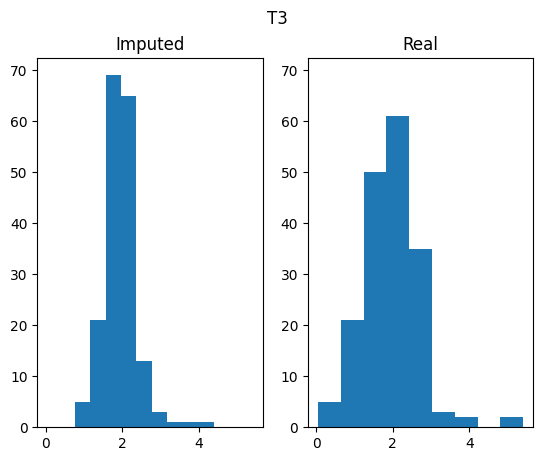

None

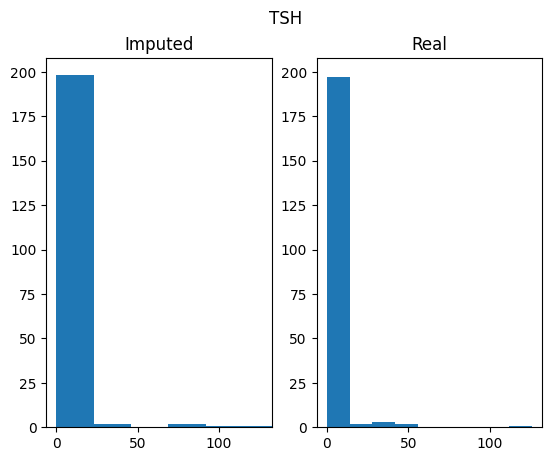

None

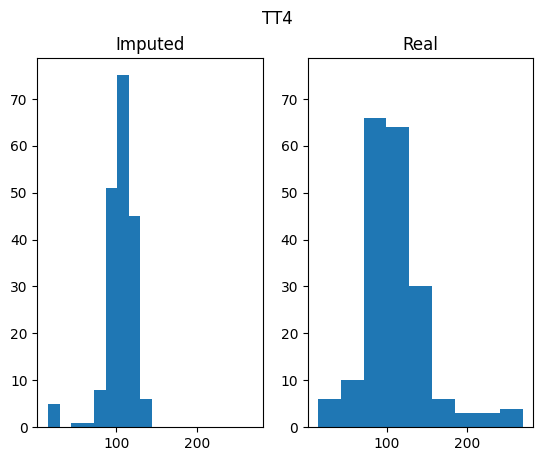

None

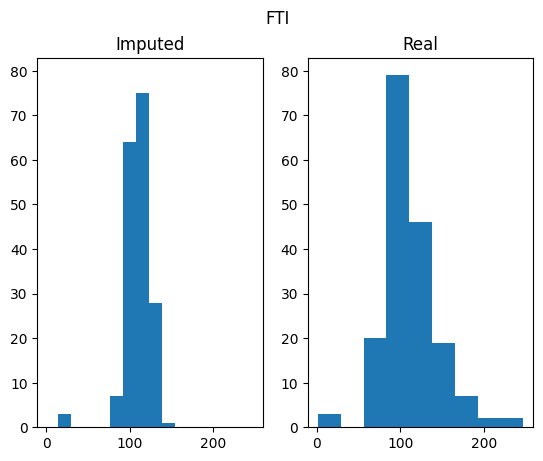

None

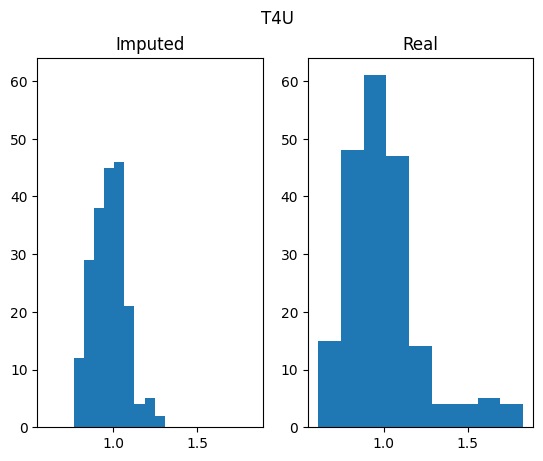

None

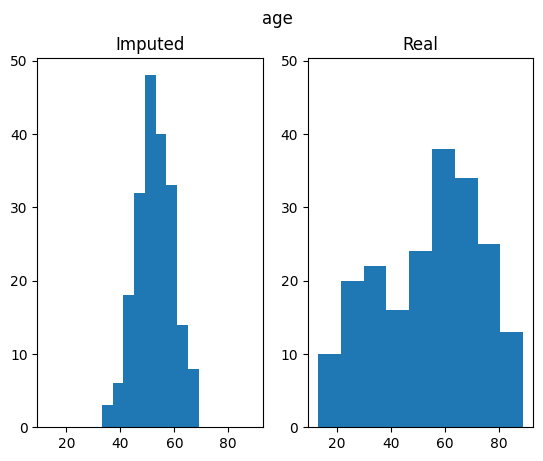

None

In [41]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, knn_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
        ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
        real_xlim = ax[1].get_xlim()
        min_val = real_xlim[0]
        max_val = real_xlim[1]
        ax[0].set_xlim((min_val, max_val))
        ax[1].set_xlim((min_val, max_val))
        ax[0].set_ylim((0, true_ylim_max))
        ax[1].set_ylim((0, true_ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

## WKNN

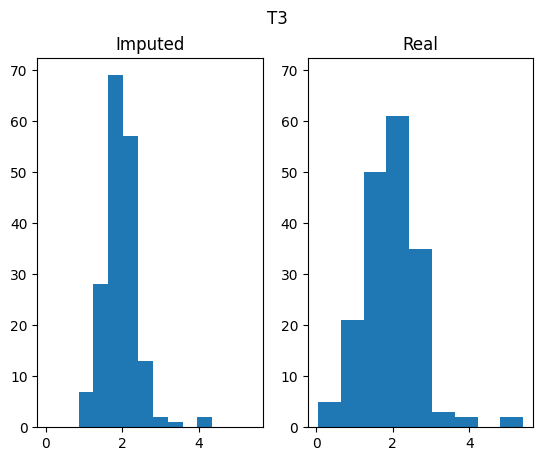

None

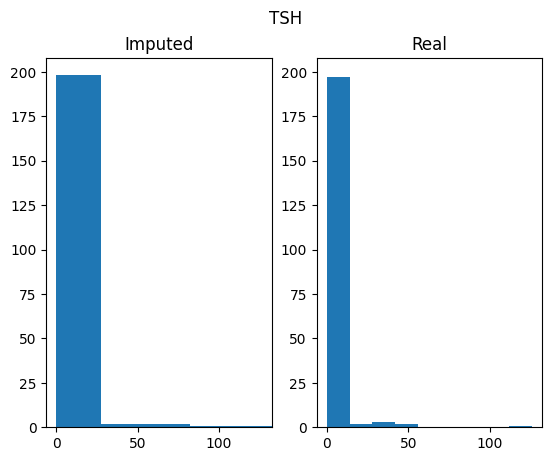

None

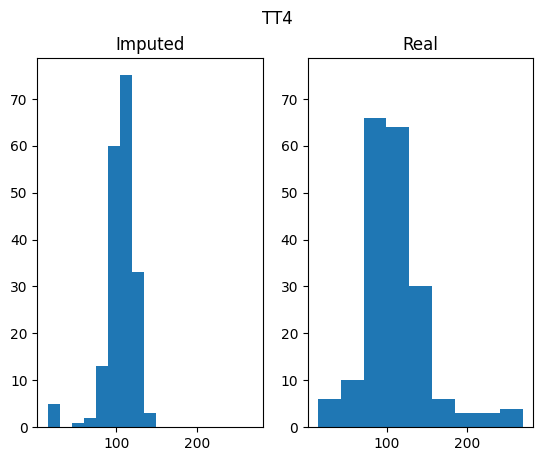

None

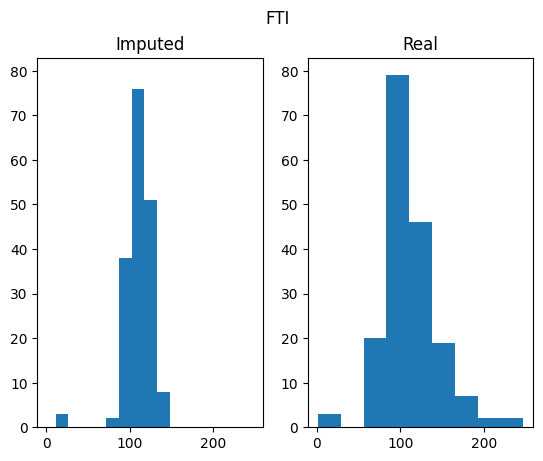

None

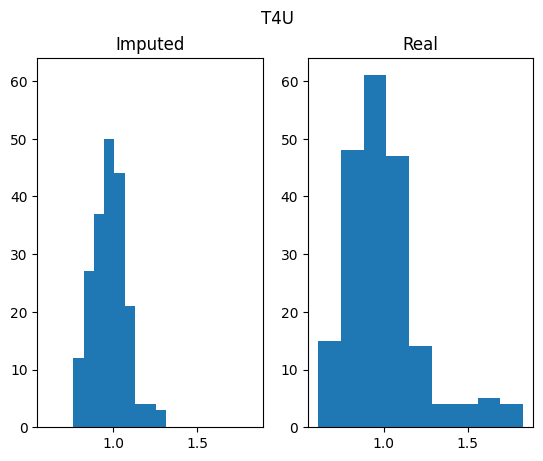

None

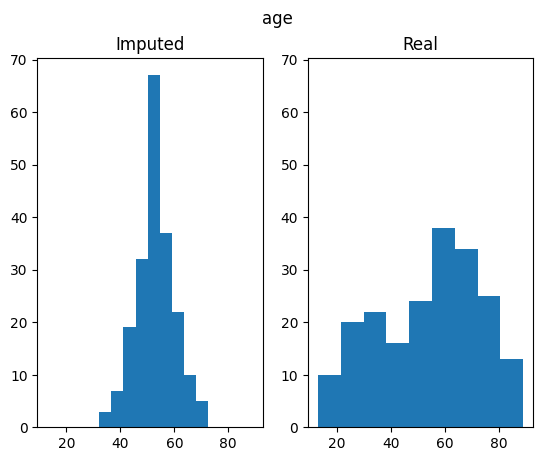

None

In [42]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, wknn_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
        ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
        real_xlim = ax[1].get_xlim()
        min_val = real_xlim[0]
        max_val = real_xlim[1]
        ax[0].set_xlim((min_val, max_val))
        ax[1].set_xlim((min_val, max_val))
        ax[0].set_ylim((0, true_ylim_max))
        ax[1].set_ylim((0, true_ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

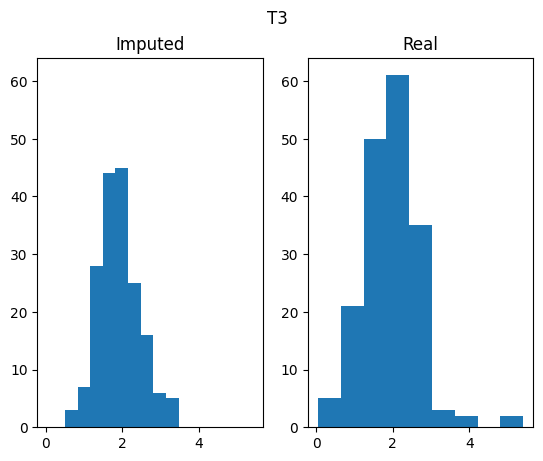

None

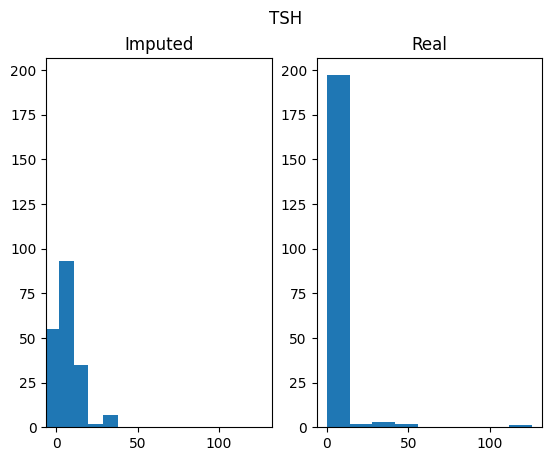

None

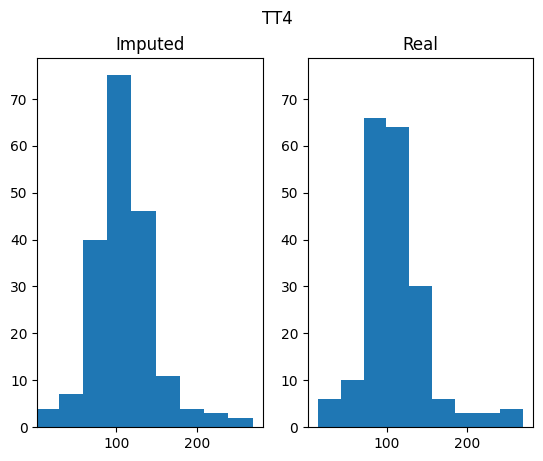

None

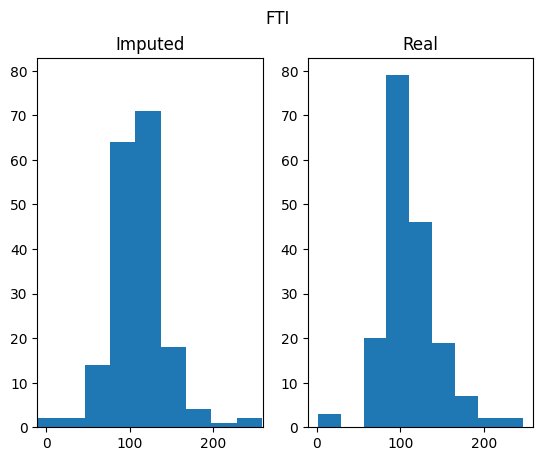

None

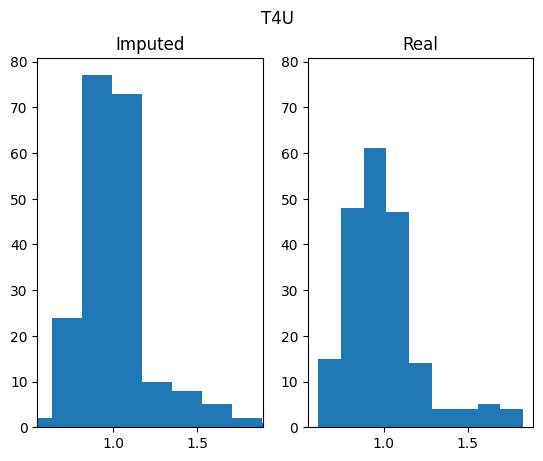

None

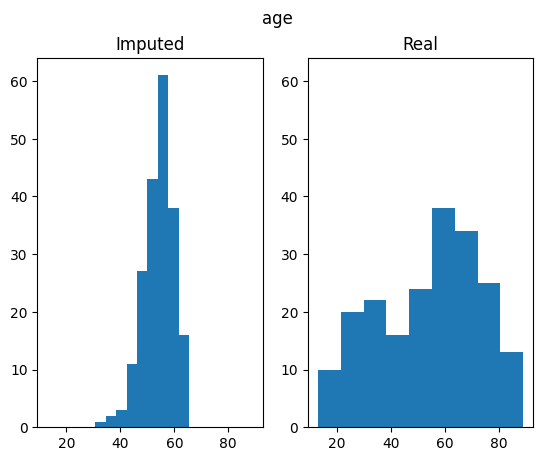

None

In [43]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
        ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
        real_xlim = ax[1].get_xlim()
        min_val = real_xlim[0]
        max_val = real_xlim[1]
        ax[0].set_xlim((min_val, max_val))
        ax[1].set_xlim((min_val, max_val))
        ax[0].set_ylim((0, true_ylim_max))
        ax[1].set_ylim((0, true_ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

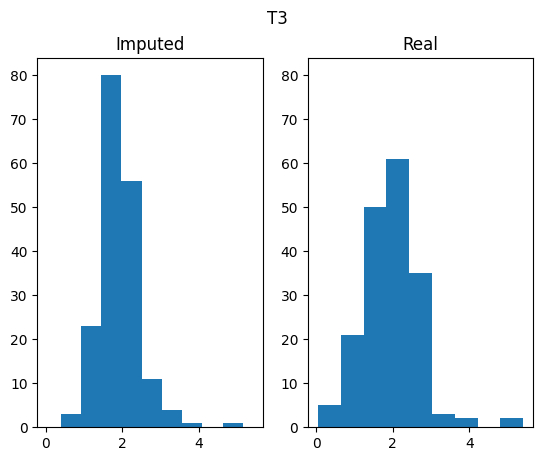

None

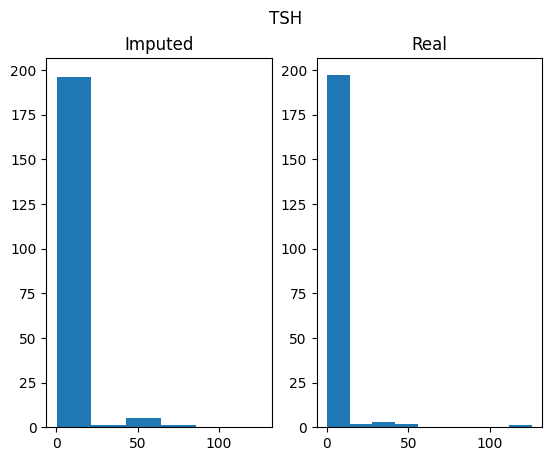

None

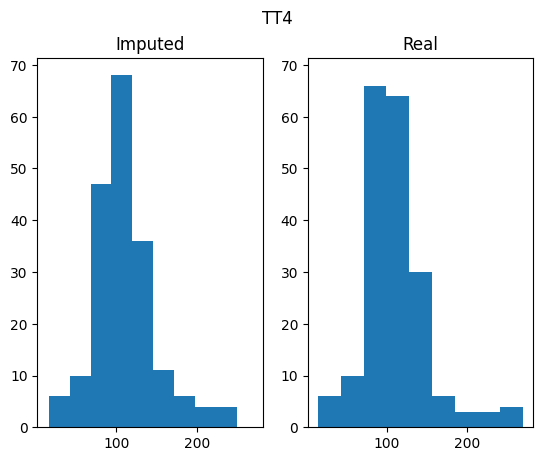

None

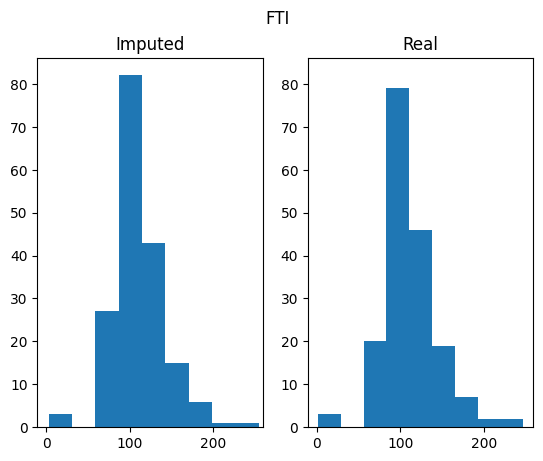

None

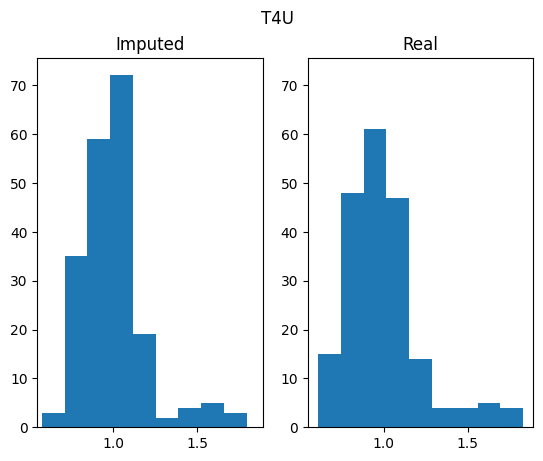

None

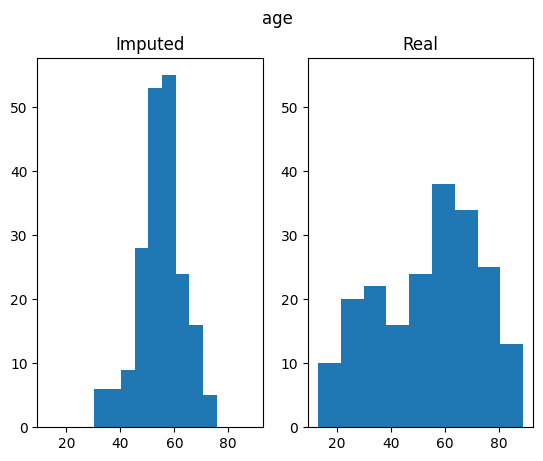

None

In [44]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_rf_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
        ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
        real_xlim = ax[1].get_xlim()
        min_val = real_xlim[0]
        max_val = real_xlim[1]
        ax[0].set_xlim((min_val, max_val))
        ax[1].set_xlim((min_val, max_val))
        ax[0].set_ylim((0, true_ylim_max))
        ax[1].set_ylim((0, true_ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

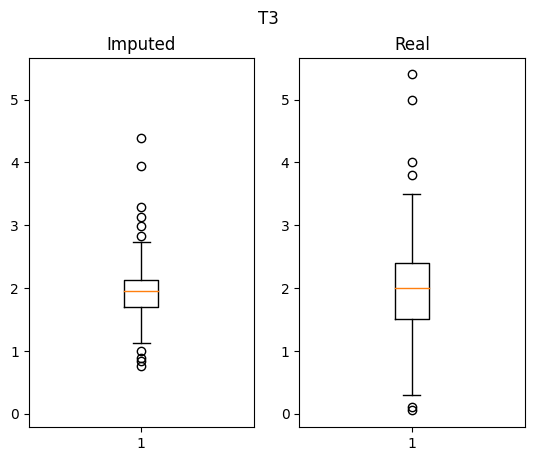

None

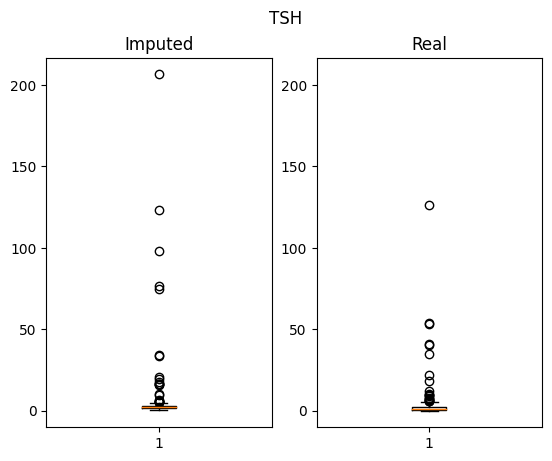

None

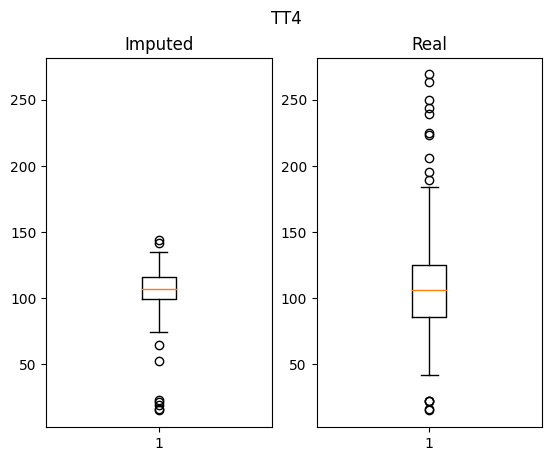

None

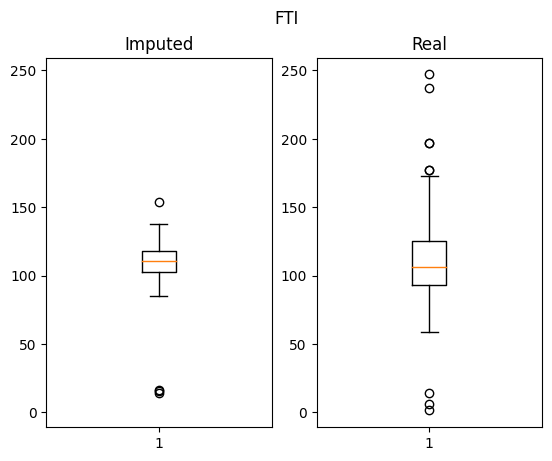

None

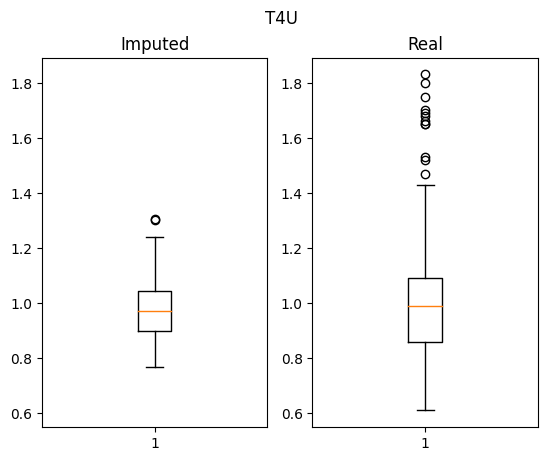

None

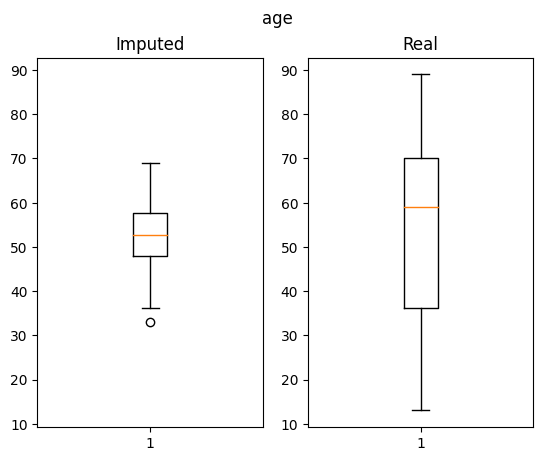

None

In [45]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, knn_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].boxplot(x=imputed_dict[col])
        ax[1].boxplot(x=real_dict[col])
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        ylim_min = min([imputed_ylim[0], real_ylim[0]])
        ylim_max = max([imputed_ylim[1], real_ylim[1]])
        ax[0].set_ylim((ylim_min, ylim_max))
        ax[1].set_ylim((ylim_min, ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

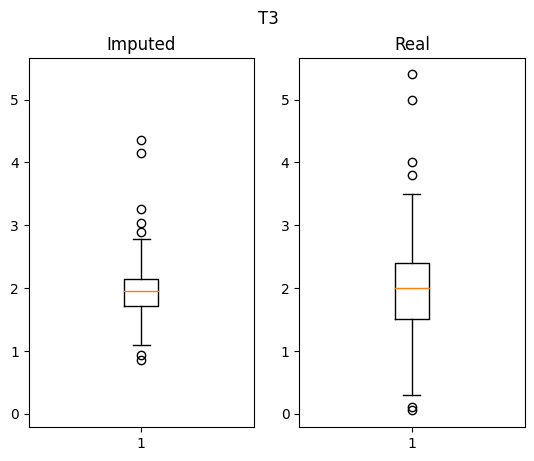

None

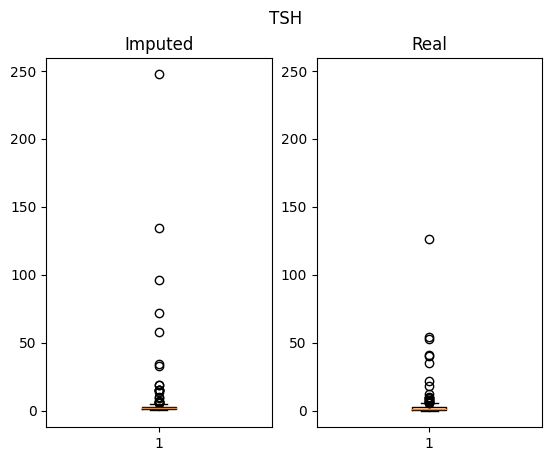

None

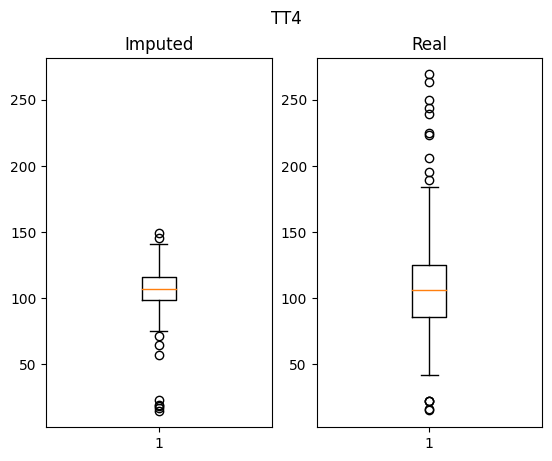

None

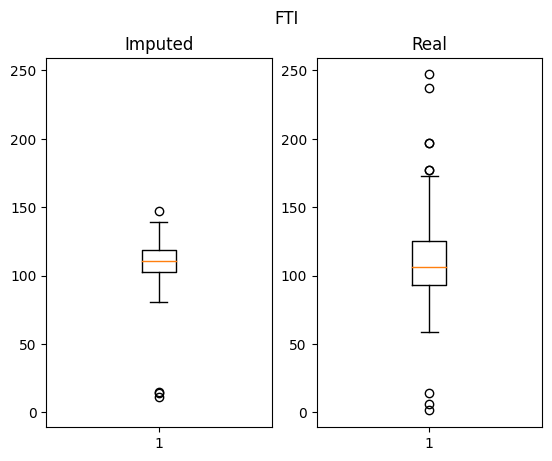

None

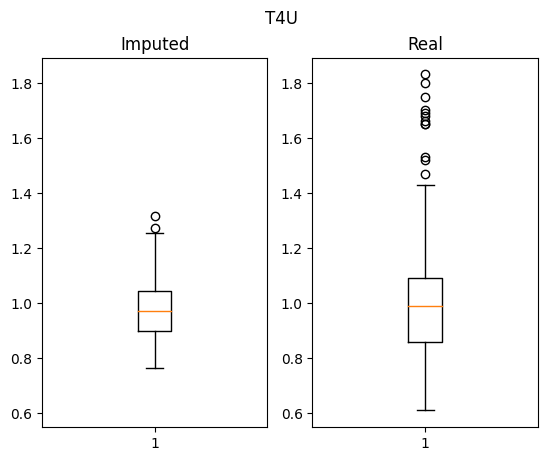

None

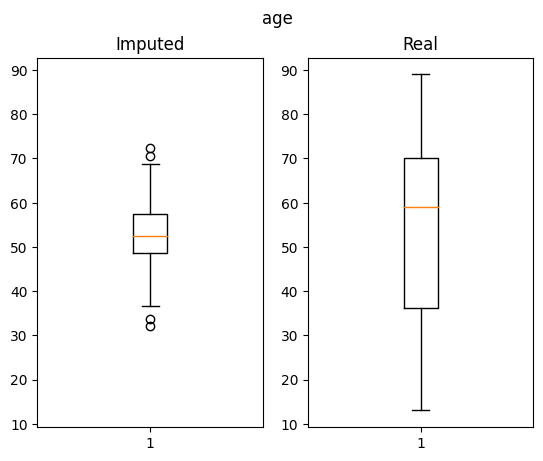

None

In [46]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, wknn_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].boxplot(x=imputed_dict[col])
        ax[1].boxplot(x=real_dict[col])
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        ylim_min = min([imputed_ylim[0], real_ylim[0]])
        ylim_max = max([imputed_ylim[1], real_ylim[1]])
        ax[0].set_ylim((ylim_min, ylim_max))
        ax[1].set_ylim((ylim_min, ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

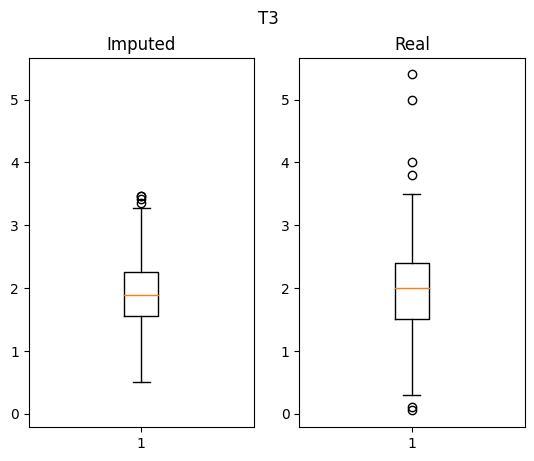

None

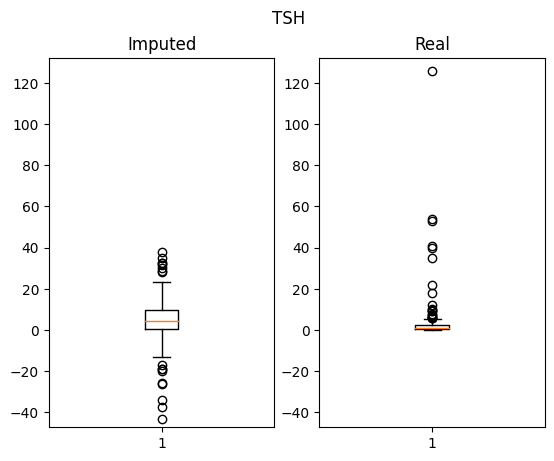

None

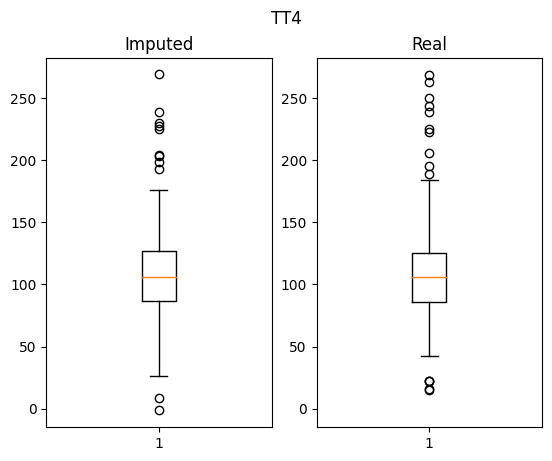

None

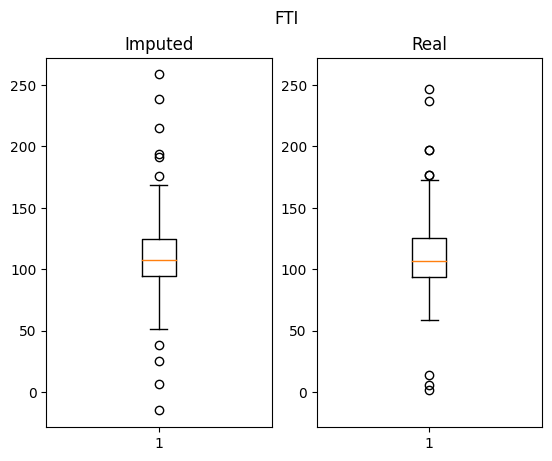

None

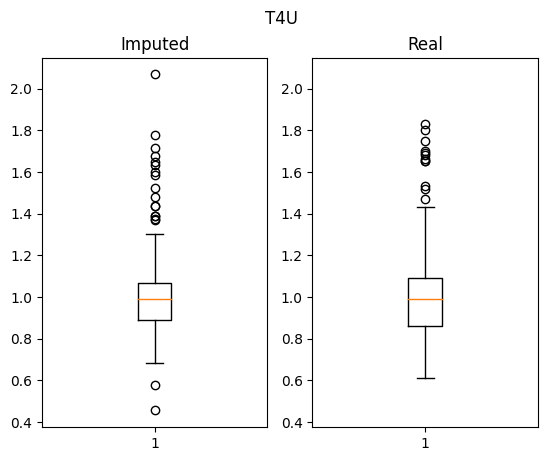

None

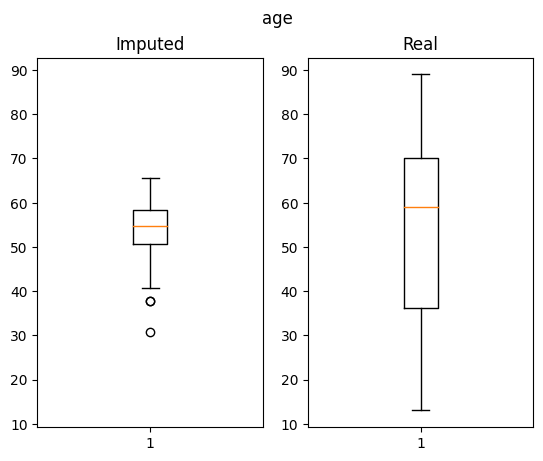

None

In [47]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].boxplot(x=imputed_dict[col])
        ax[1].boxplot(x=real_dict[col])
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        ylim_min = min([imputed_ylim[0], real_ylim[0]])
        ylim_max = max([imputed_ylim[1], real_ylim[1]])
        ax[0].set_ylim((ylim_min, ylim_max))
        ax[1].set_ylim((ylim_min, ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

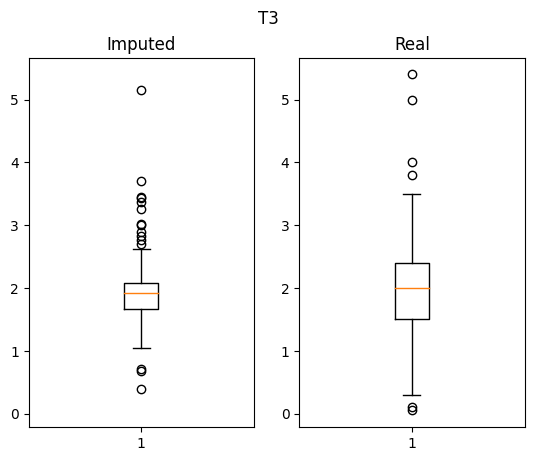

None

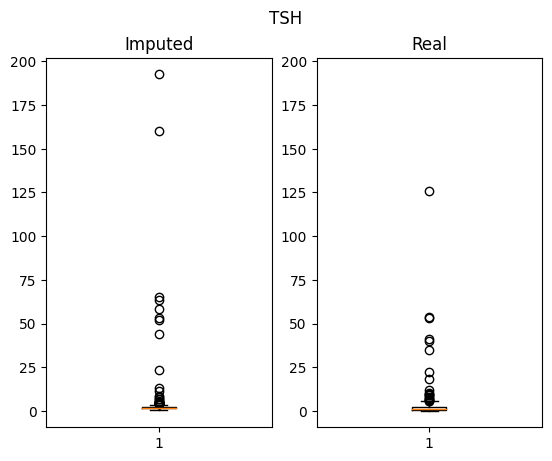

None

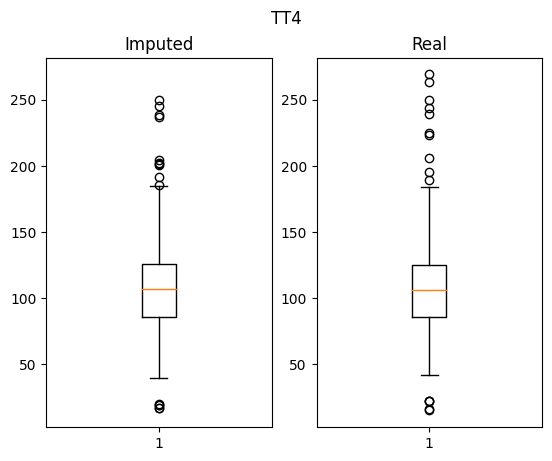

None

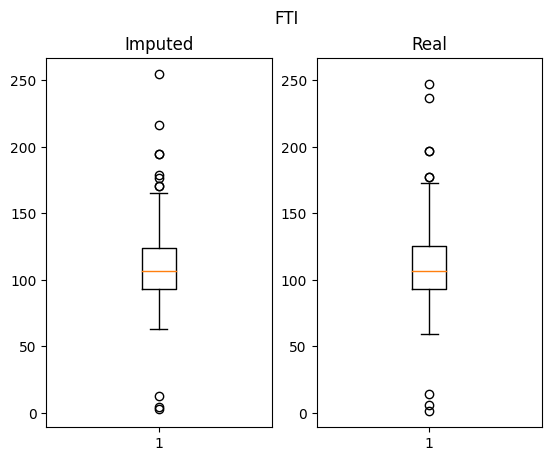

None

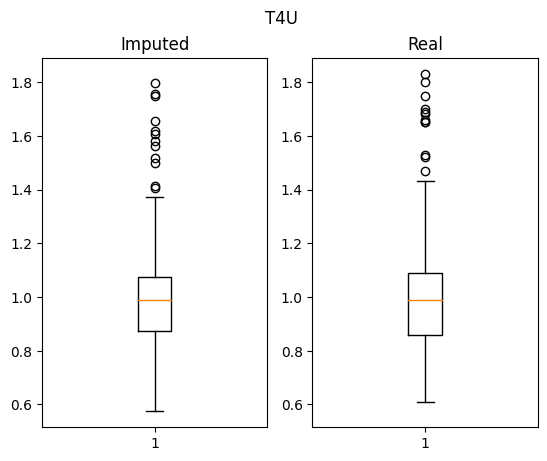

None

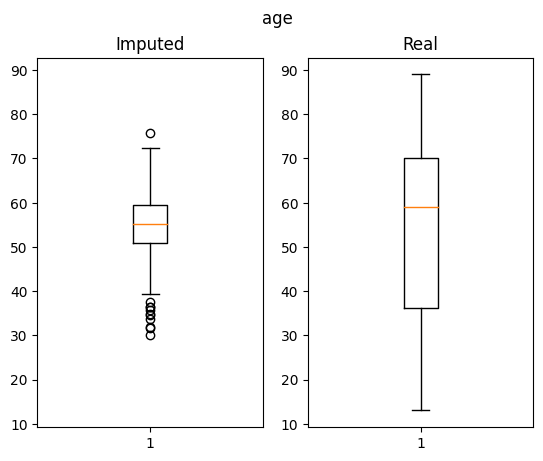

None

In [48]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_rf_imputed_df)
for col in sel_qual_cols:
    if col not in sel_cat_cols:
        _, ax = plt.subplots(1, 2)
        ax[0].boxplot(x=imputed_dict[col])
        ax[1].boxplot(x=real_dict[col])
        imputed_ylim = ax[0].get_ylim()
        real_ylim = ax[1].get_ylim()
        ylim_min = min([imputed_ylim[0], real_ylim[0]])
        ylim_max = max([imputed_ylim[1], real_ylim[1]])
        ax[0].set_ylim((ylim_min, ylim_max))
        ax[1].set_ylim((ylim_min, ylim_max))
        ax[0].set_title("Imputed")
        ax[1].set_title("Real")
        plt.suptitle(col)
        display(plt.show())

In [49]:
imputed_sqr_err(sel_qual_cols, knn_imputed_df)

{'T3': 0.4056373128491622,
 'TSH': 267.18662072681155,
 'TT4': 1110.13545,
 'FTI': 579.9216207747418,
 'T4U': 0.027149885940594063,
 'age': 372.6883168316834,
 'I131_treatment': 0,
 'on_antithyroid_meds': 0,
 'thyroid_surgery': 0,
 'on_thyroxine': 0,
 'lithium': 0,
 'psych': 0,
 'sick': 0,
 'tumor': 0,
 'goitre': 0,
 'pregnant': 0,
 'sex': 0}

In [50]:
imputed_sqr_err(sel_qual_cols, wknn_imputed_df)

{'T3': 0.42989467733532205,
 'TSH': 343.02987429269626,
 'TT4': 1071.9418707604616,
 'FTI': 585.7681197769575,
 'T4U': 0.027665672312823672,
 'age': 362.9496603639167,
 'I131_treatment': 0,
 'on_antithyroid_meds': 0,
 'thyroid_surgery': 0,
 'on_thyroxine': 0,
 'lithium': 0,
 'psych': 0,
 'sick': 0,
 'tumor': 0,
 'goitre': 0,
 'pregnant': 0,
 'sex': 0}

In [51]:
imputed_sqr_err(sel_qual_cols, mice_imputed_df)

{'T3': 0.36332737429345924,
 'TSH': 153.70275389977016,
 'TT4': 51.9872451453681,
 'FTI': 87.16686429343207,
 'T4U': 0.004179090218756494,
 'age': 294.87390687735785,
 'I131_treatment': 0,
 'on_antithyroid_meds': 0,
 'thyroid_surgery': 0,
 'on_thyroxine': 0,
 'lithium': 0,
 'psych': 0,
 'sick': 0,
 'tumor': 0,
 'goitre': 0,
 'pregnant': 0,
 'sex': 0}

In [52]:
display(knn_imputed_df[real_cols].mean())
display(knn_imputed_df[imputed_cols].mean())

T3 (real)                       1.943307
TSH (real)                      6.219702
TT4 (real)                    107.135492
FTI (real)                    110.876425
T4U (real)                      0.980846
age (real)                     53.206390
I131_treatment (real)           0.018998
on_antithyroid_meds (real)      0.009499
thyroid_surgery (real)          0.022453
on_thyroxine (real)             0.107945
lithium (real)                  0.009499
psych (real)                    0.055268
sick (real)                     0.044041
tumor (real)                    0.023316
goitre (real)                   0.011226
pregnant (real)                 0.012953
sex (real)                      0.335060
dtype: float64

T3 (imputed)                       1.940823
TSH (imputed)                      6.608151
TT4 (imputed)                    106.159430
FTI (imputed)                    110.740527
T4U (imputed)                      0.975969
age (imputed)                     52.959931
I131_treatment (imputed)           0.018998
on_antithyroid_meds (imputed)      0.009499
thyroid_surgery (imputed)          0.022453
on_thyroxine (imputed)             0.107945
lithium (imputed)                  0.009499
psych (imputed)                    0.055268
sick (imputed)                     0.044041
tumor (imputed)                    0.023316
goitre (imputed)                   0.011226
pregnant (imputed)                 0.012953
sex (imputed)                      0.335060
dtype: float64

In [53]:
display(knn_imputed_df[real_cols].std())
display(knn_imputed_df[imputed_cols].std())

T3 (real)                      0.852304
TSH (real)                    30.245906
TT4 (real)                    37.402672
FTI (real)                    36.213337
T4U (real)                     0.194106
age (real)                    19.173629
I131_treatment (real)          0.136578
on_antithyroid_meds (real)     0.097041
thyroid_surgery (real)         0.148214
on_thyroxine (real)            0.310445
lithium (real)                 0.097041
psych (real)                   0.228601
sick (real)                    0.205276
tumor (real)                   0.150971
goitre (real)                  0.105403
pregnant (real)                0.113122
sex (real)                     0.472216
dtype: float64

T3 (imputed)                      0.818552
TSH (imputed)                    30.958516
TT4 (imputed)                    34.276575
FTI (imputed)                    34.495579
T4U (imputed)                     0.174657
age (imputed)                    17.644075
I131_treatment (imputed)          0.136578
on_antithyroid_meds (imputed)     0.097041
thyroid_surgery (imputed)         0.148214
on_thyroxine (imputed)            0.310445
lithium (imputed)                 0.097041
psych (imputed)                   0.228601
sick (imputed)                    0.205276
tumor (imputed)                   0.150971
goitre (imputed)                  0.105403
pregnant (imputed)                0.113122
sex (imputed)                     0.472216
dtype: float64

In [54]:
display(wknn_imputed_df[real_cols].mean())
display(wknn_imputed_df[imputed_cols].mean())

T3 (real)                       1.943307
TSH (real)                      6.219702
TT4 (real)                    107.135492
FTI (real)                    110.876425
T4U (real)                      0.980846
age (real)                     53.206390
I131_treatment (real)           0.018998
on_antithyroid_meds (real)      0.009499
thyroid_surgery (real)          0.022453
on_thyroxine (real)             0.107945
lithium (real)                  0.009499
psych (real)                    0.055268
sick (real)                     0.044041
tumor (real)                    0.023316
goitre (real)                   0.011226
pregnant (real)                 0.012953
sex (real)                      0.335060
dtype: float64

T3 (imputed)                       1.941553
TSH (imputed)                      6.623262
TT4 (imputed)                    106.130356
FTI (imputed)                    110.747747
T4U (imputed)                      0.976224
age (imputed)                     52.967032
I131_treatment (imputed)           0.018998
on_antithyroid_meds (imputed)      0.009499
thyroid_surgery (imputed)          0.022453
on_thyroxine (imputed)             0.107945
lithium (imputed)                  0.009499
psych (imputed)                    0.055268
sick (imputed)                     0.044041
tumor (imputed)                    0.023316
goitre (imputed)                   0.011226
pregnant (imputed)                 0.012953
sex (imputed)                      0.335060
dtype: float64

In [55]:
display(wknn_imputed_df[real_cols].std())
display(wknn_imputed_df[imputed_cols].std())

T3 (real)                      0.852304
TSH (real)                    30.245906
TT4 (real)                    37.402672
FTI (real)                    36.213337
T4U (real)                     0.194106
age (real)                    19.173629
I131_treatment (real)          0.136578
on_antithyroid_meds (real)     0.097041
thyroid_surgery (real)         0.148214
on_thyroxine (real)            0.310445
lithium (real)                 0.097041
psych (real)                   0.228601
sick (real)                    0.205276
tumor (real)                   0.150971
goitre (real)                  0.105403
pregnant (real)                0.113122
sex (real)                     0.472216
dtype: float64

T3 (imputed)                      0.818087
TSH (imputed)                    31.199427
TT4 (imputed)                    34.294026
FTI (imputed)                    34.504213
T4U (imputed)                     0.174702
age (imputed)                    17.668910
I131_treatment (imputed)          0.136578
on_antithyroid_meds (imputed)     0.097041
thyroid_surgery (imputed)         0.148214
on_thyroxine (imputed)            0.310445
lithium (imputed)                 0.097041
psych (imputed)                   0.228601
sick (imputed)                    0.205276
tumor (imputed)                   0.150971
goitre (imputed)                  0.105403
pregnant (imputed)                0.113122
sex (imputed)                     0.472216
dtype: float64

In [56]:
neighbour_range = range(1, 17)

In [57]:
knn_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "kNN", "n_neighbors", "imputer", "neighbours", neighbour_range,
                              config={}, estimator_config={})

In [58]:
wknn_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "WkNN", "n_neighbors", "imputer", "neighbours", neighbour_range,
                               config={}, estimator_config={})

In [59]:
import seaborn as sns

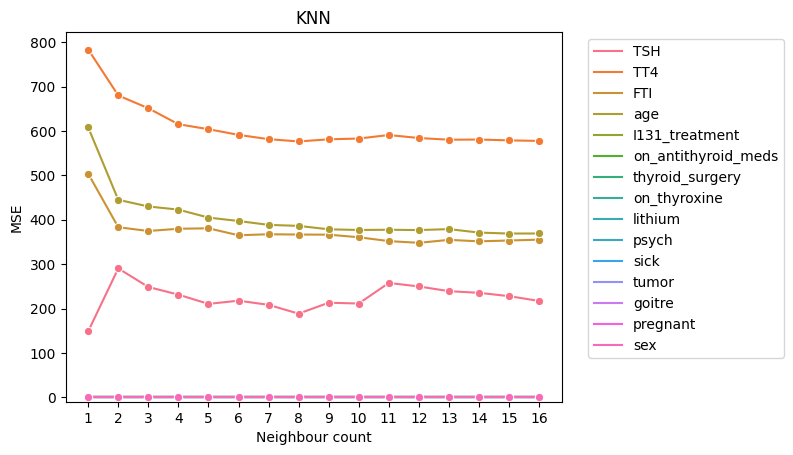

In [60]:
sns.lineplot(data=knn_mse_df[(knn_mse_df["col"] != "T3") & (knn_mse_df["col"] != "T4U")], x="neighbours", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("KNN")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

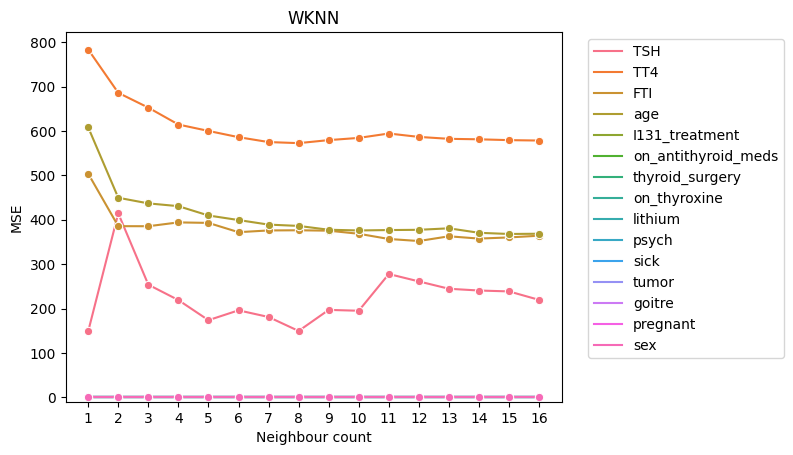

In [61]:
sns.lineplot(data=wknn_mse_df[(wknn_mse_df["col"] != "T3") & (wknn_mse_df["col"] != "T4U")], x="neighbours", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.title("WKNN")
plt.xticks(neighbour_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

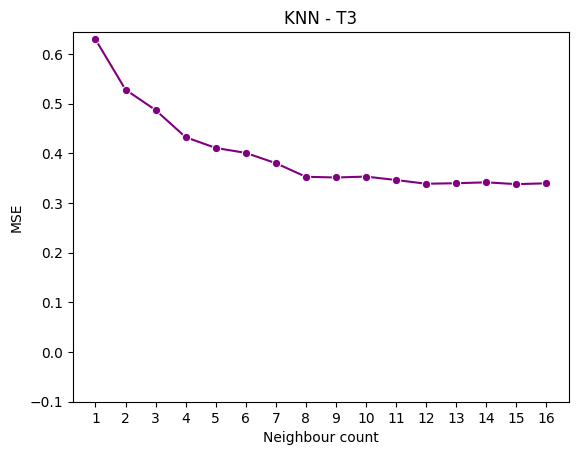

In [62]:
sns.lineplot(data=knn_mse_df[(knn_mse_df["col"] == "T3")], x="neighbours", y="val", marker="o", color="purple")
plt.ylim(-0.1, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("KNN - T3")
plt.show()

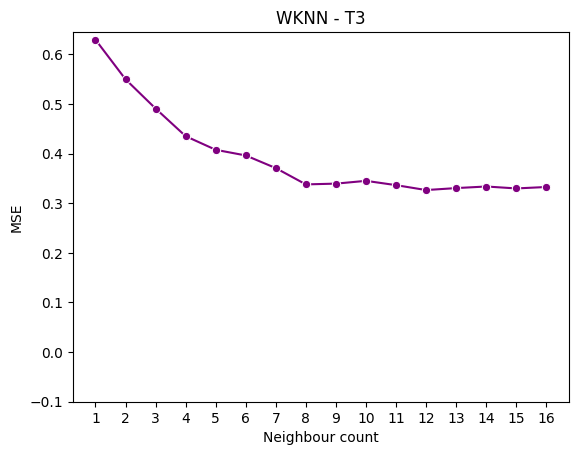

In [63]:
sns.lineplot(data=wknn_mse_df[(wknn_mse_df["col"] == "T3")], x="neighbours", y="val", marker="o", color="purple")
plt.ylim(-0.1, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("WKNN - T3")
plt.show()

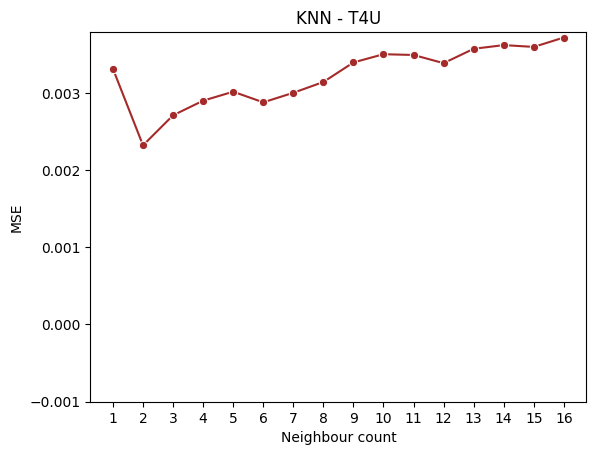

In [64]:
sns.lineplot(data=knn_mse_df[(knn_mse_df["col"] == "T4U")], x="neighbours", y="val", marker="o", color="brown")
plt.ylim(-0.001, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("KNN - T4U")
plt.show()

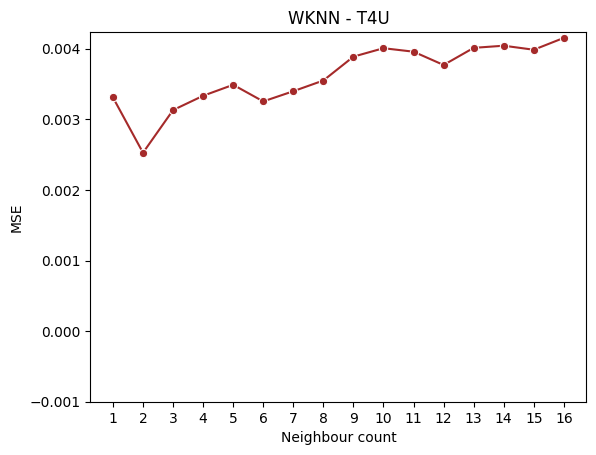

In [65]:
sns.lineplot(data=wknn_mse_df[(wknn_mse_df["col"] == "T4U")], x="neighbours", y="val", marker="o", color="brown")
plt.ylim(-0.001, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("WKNN - T4U")
plt.show()

In [66]:
iter_range = []
for i in range(0, 20):
    iter_range.append(i)

In [67]:
mice_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE", "max_iter", "imputer", "max_iters", iter_range,
                               config={
                                   "random_state": random_state
                               }, estimator_config={})

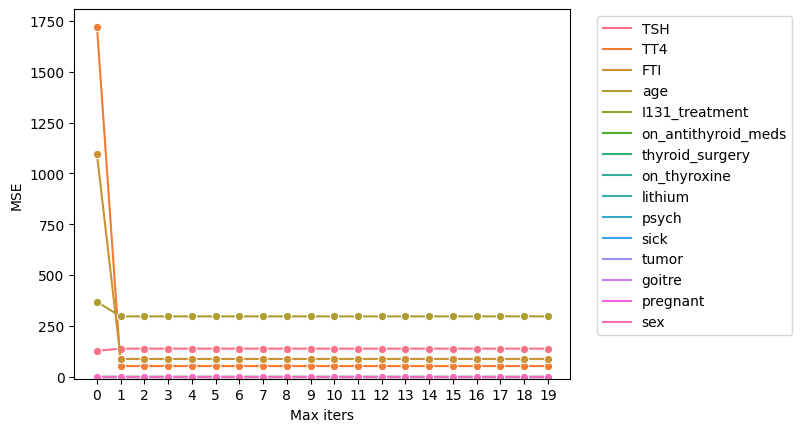

In [68]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] != "T3") & (mice_mse_df["col"] != "T4U")], x="max_iters", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

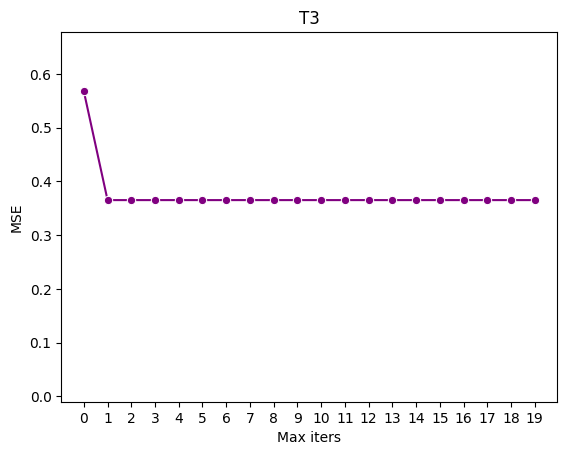

In [69]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] == "T3")], x="max_iters", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T3")
plt.show()

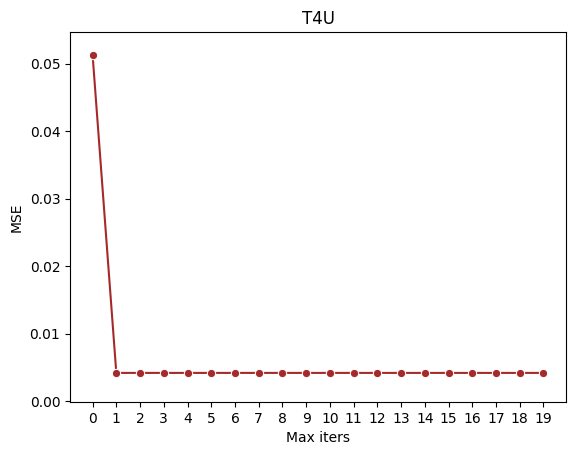

In [70]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] == "T4U")], x="max_iters", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [71]:
mice_rf_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE RF", "max_iter", "imputer", "max_iters", iter_range, 
                                  config={
                                      "random_state": random_state
                                      }, estimator_config={
                                          "max_depth": 100,
                                          "random_state": random_state,
                                          "n_estimators": 10,
                                          "max_samples": 0.5,
                                          "bootstrap": True
                                        })

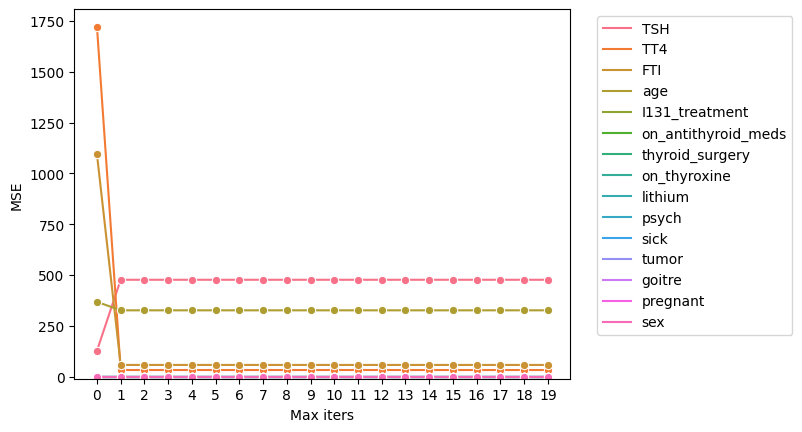

In [72]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] != "T3") & (mice_rf_mse_df["col"] != "T4U")], x="max_iters", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

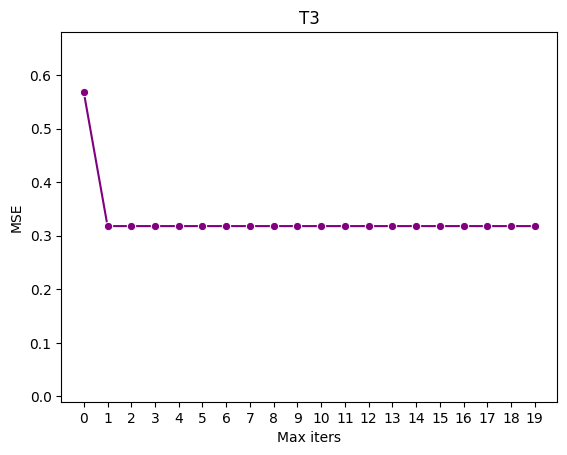

In [73]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] == "T3")], x="max_iters", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T3")
plt.show()

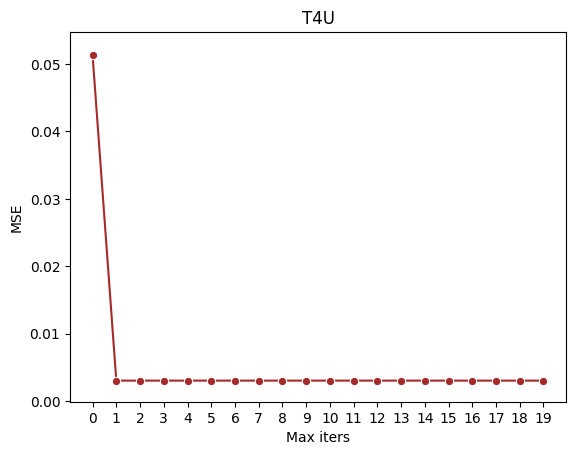

In [74]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] == "T4U")], x="max_iters", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [75]:
depths = [1,2,3,4,5,6,7,8,9,10,15,20,30,50,100]

In [76]:
mice_rf_depth_mse_df, _ = run_comparing(real_df, curr_df, missing_vals_idxs, picked_cols, "MICE RF", "max_depth", "estimator", "depth", depths, 
                                        config={
                                            "random_state": random_state,
                                            "max_iter": 100
                                        }, estimator_config={
                                            "random_state": random_state,
                                            "n_estimators": 10,
                                            "max_samples": 0.5,
                                            "bootstrap": True
                                        })

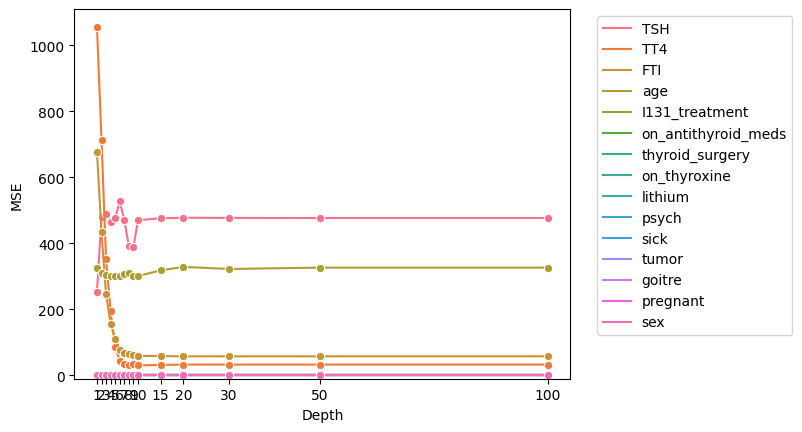

In [77]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] != "T3") & (mice_rf_depth_mse_df["col"] != "T4U")], x="depth", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depths)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

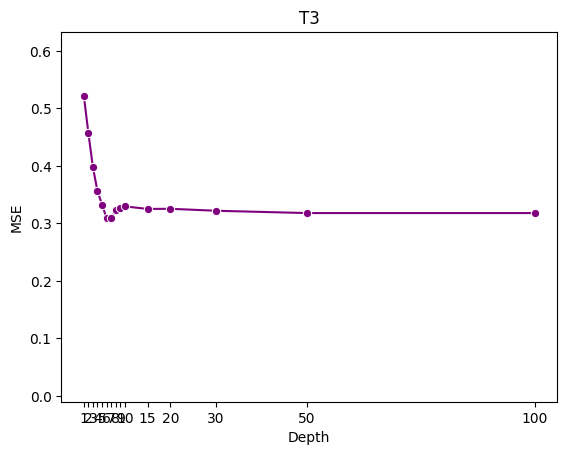

In [78]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] == "T3")], x="depth", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depths)
#plt.xscale("log")
plt.title("T3")
plt.show()

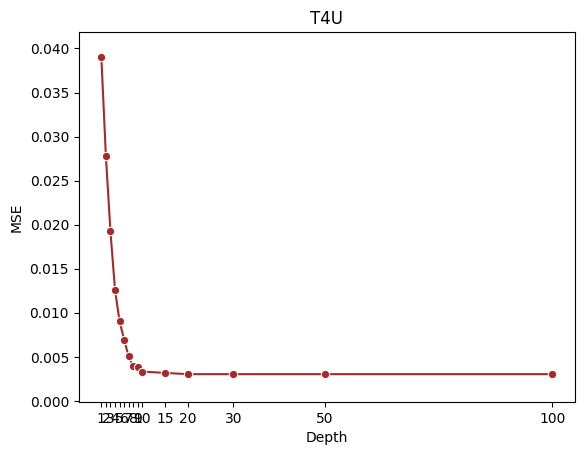

In [79]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] == "T4U")], x="depth", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depths)
#plt.xscale("log")
plt.title("T4U")
plt.show()